# Predicting Bushfires in Australia: Part 2

### Data Dictionary

- Latitude: Center of nominal 375 m fire pixel.
- Longitude:  Center of nominal 375 m fire pixel.
- Brightness: Channel 21/22 brightness temperature of the fire pixel measured in Kelvin.
- Scan: The algorithm produces approximately 375 m pixels at nadir. Scan and track reflect actual pixel size.
- Track: The algorithm produces approximately 375 m pixels at nadir. Scan and track reflect actual pixel size.
- Acquisition Date: Date of VIIRS acquisition.
- Acquisition Time: Time of acquisition/overpass of the satellite (in UTC).
- Satellite: N = Suomi National Polar-orbiting Partnership (Suomi NPP). N20 = NOAA-20 (JPSS1). N21 = NOAA-21 (JPSS2).
- Instrument: VIIRS
- Confidence: Helps users gauge the quality of individual hotspot/fire pixels. Confidence values are set to low (l), nominal (n), and high (h).
- Version: Version (collection and source)
- Bright_t31: Channel 31 brightness temperature of the fire pixel measured in Kelvin.
- frp: Fire Radiative Power (MW)
- Daynight: D= Daytime fire, N= Nighttime fire
- Type: Inferred hot spot type. 0 = presumed vegetation fire, 1 = active volcano, 2 = other static land source, 3 = offshore detection (includes all detections over water)

VIIRS vs MODIS Differences
The spatial resolution of the active fire detection pixel from MODIS is 1 km. The VIIRS active fire products provides an improved spatial resolution, as compared to MODIS. The spatial resolution of the active fire detection pixel for VIIRS is 375 m. Additionally, VIIRS is able to detect smaller fires and can help delineate perimeters of ongoing large fires.

- TemperatureMean: Mean Temperature (degrees C)
- RainSum: Total rainfall (mm)
- RelativeHumidityMean: Mean relative humidity (%RH)

### Import Libraries

In [5]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
# Read in the Final DataFrame from previous notebook
final_merged_df = pd.read_pickle('final_merged_df.pkl')
final_merged_df.sample(5)

,suburb,state,TemperatureMean,TemperatureMax,TemperatureMin,RainSum,date,brightness,scan,track,acq_time,confidence,bright_t31,frp,daynight,type,area,bf_area,bf_area_pct
2909876,cement mills,QLD,13.061000,18.086000,6.136000,0.0,2022-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,401.476801,297.979379,0.742208
10158292,pointer mountain,NSW,13.802583,19.338000,10.138000,0.0,2020-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.303501,43.303501,1.000000
9042918,mungindi (nsw),NSW,31.966667,37.450000,27.850000,0.1,2023-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11169589,selene,QLD,23.896500,30.996500,17.646500,0.1,2020-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.335899,7.840269,0.235190
10449489,redbournberry,NSW,20.594084,35.529503,11.979501,0.1,2020-01-05,346.83,0.38,0.36,342.0,1.0,306.27,4.06,0.0,0.0,4.438698,0.573281,0.129155


In [7]:
final_merged_df.head()

,suburb,state,TemperatureMean,TemperatureMax,TemperatureMin,RainSum,date,brightness,scan,track,acq_time,confidence,bright_t31,frp,daynight,type,area,bf_area,bf_area_pct
0,aarons pass,NSW,18.106417,30.471000,8.771000,0.0,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.838001,82.836363,0.99998
1,aarons pass,NSW,19.798082,31.671001,11.521000,0.0,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.838001,82.836363,0.99998
2,aarons pass,NSW,24.583502,36.521000,17.071001,0.0,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.838001,82.836363,0.99998
3,aarons pass,NSW,25.281418,40.121002,14.370999,0.0,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.838001,82.836363,0.99998
4,aarons pass,NSW,15.487667,23.071001,11.471000,0.0,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.838001,82.836363,0.99998


In [8]:
final_merged_df.shape

(14232351, 19)

In [9]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14232351 entries, 0 to 14232350
Data columns (total 19 columns):
 #   Column           Dtype         
---  ------           -----         
 0   suburb           object        
 1   state            object        
 2   TemperatureMean  float64       
 3   TemperatureMax   float64       
 4   TemperatureMin   float64       
 5   RainSum          float64       
 6   date             datetime64[ns]
 7   brightness       float64       
 8   scan             float64       
 9   track            float64       
 10  acq_time         float64       
 11  confidence       float64       
 12  bright_t31       float64       
 13  frp              float64       
 14  daynight         float64       
 15  type             float64       
 16  area             float64       
 17  bf_area          float64       
 18  bf_area_pct      float64       
dtypes: datetime64[ns](1), float64(16), object(2)
memory usage: 2.0+ GB


In [10]:
# Rename columns
final_merged_df.rename(columns={'TemperatureMean': 'MeanTemp', 'TemperatureMax': 'MaxTemp', 'TemperatureMin': 'MinTemp'}, inplace=True)
final_merged_df.sample(10)

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,date,brightness,scan,track,acq_time,confidence,bright_t31,frp,daynight,type,area,bf_area,bf_area_pct
2727352,caravonica,QLD,22.084333,25.501000,19.401000,0.0,2023-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.638597,0.886078,0.191023
8917155,mount whitestone,QLD,16.008501,21.358500,13.258500,2.2,2022-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.814055,35.279921,0.694295
6720465,kiar,NSW,17.048166,24.469000,12.318999,0.4,2024-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.592612,4.586827,0.998740
310939,ascot (brisbane - qld),QLD,21.181501,26.519001,17.719000,7.5,2023-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4920780,fords bridge,NSW,22.038750,34.482502,11.882501,2.2,2020-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3778.165205,3778.001289,0.999957
5498025,gostwyck,NSW,8.894334,13.636001,5.936000,0.0,2024-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.203126,16.665053,0.197915
8966755,mulgoa,NSW,12.239583,18.400000,6.500000,0.0,2020-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.378192,53.650811,0.986624
2204103,cairns city,QLD,26.148916,29.501000,23.451000,0.1,2020-12-04,319.93,0.4,0.37,1534.0,1.0,295.47,1.41,1.0,0.0,1.814375,NaN,0.000000
5460381,goonoo goonoo,NSW,22.240084,25.975500,19.875502,35.1,2022-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.938000,33.938000,1.000000
11215042,sheedys gully,NSW,6.618166,14.701500,1.851500,0.5,2021-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.620664,1.520569,0.938238


In [11]:
# Create a bushfire y/n column, y=there is a fire
final_merged_df['bushfire_y_n'] = np.where(final_merged_df['acq_time'].isna(), 0, 1)

# Display the updated DataFrame
final_merged_df.sample(10)

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,date,brightness,scan,track,acq_time,confidence,bright_t31,frp,daynight,type,area,bf_area,bf_area_pct,bushfire_y_n
13646845,windorah,QLD,34.788250,42.019500,26.319500,0.0,2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8847.336559,284.296540,0.032134,0
1257919,bohle plains,QLD,21.365000,25.577501,18.277500,0.0,2021-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.672657,18.868147,0.595724,0
4448942,edensor park,NSW,7.910750,9.804500,6.004500,0.0,2022-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.102573,0.015407,0.004966,0
478468,balgowan (qld),QLD,22.895834,28.950000,17.500000,0.1,2024-03-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
11002351,sadleir,NSW,20.939917,29.154500,12.304500,0.0,2023-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.901315,0.066495,0.073776,0
13332697,weemelah,NSW,9.473666,16.319500,2.919500,0.0,2021-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,579.533546,579.159738,0.999355,0
14142575,yarrowyck,NSW,14.739417,19.078999,8.979000,0.1,2021-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,373.687513,256.991959,0.687719,0
9622200,oakdale (qld),QLD,19.510000,26.322498,16.372500,1.6,2020-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
12581399,townsville city,QLD,27.179583,31.477500,23.277500,0.0,2023-12-10,351.04,0.5,0.41,341.0,1.0,308.77,6.57,0.0,0.0,1.959224,0.127080,0.064863,1
3024271,chisholm (nsw),NSW,20.247751,27.366500,13.866501,0.0,2024-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [12]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14232351 entries, 0 to 14232350
Data columns (total 20 columns):
 #   Column        Dtype         
---  ------        -----         
 0   suburb        object        
 1   state         object        
 2   MeanTemp      float64       
 3   MaxTemp       float64       
 4   MinTemp       float64       
 5   RainSum       float64       
 6   date          datetime64[ns]
 7   brightness    float64       
 8   scan          float64       
 9   track         float64       
 10  acq_time      float64       
 11  confidence    float64       
 12  bright_t31    float64       
 13  frp           float64       
 14  daynight      float64       
 15  type          float64       
 16  area          float64       
 17  bf_area       float64       
 18  bf_area_pct   float64       
 19  bushfire_y_n  int32         
dtypes: datetime64[ns](1), float64(16), int32(1), object(2)
memory usage: 2.1+ GB


In [13]:
final_merged_df.isnull().sum()

suburb                 0
state                  0
MeanTemp               0
MaxTemp                0
MinTemp                0
RainSum                0
date                   0
brightness      13007935
scan            13007935
track           13007935
acq_time        13007935
confidence      13007935
bright_t31      13007935
frp             13007935
daynight        13007935
type            13007935
area             1881576
bf_area          3289304
bf_area_pct      1881576
bushfire_y_n           0
dtype: int64

In [14]:
# Lots of missing data where there is no bushfire for a suburb/day combination

## EDA and Data Visualisation

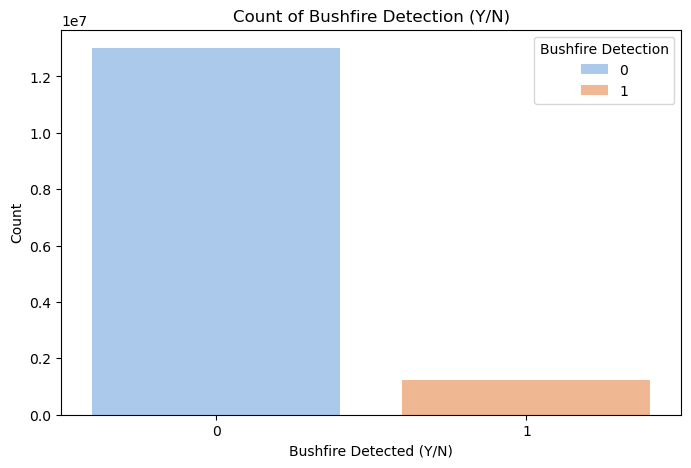

In [16]:
# What is the split of bushfire y/n?
bushfire_counts = final_merged_df['bushfire_y_n'].value_counts().reset_index()
bushfire_counts.columns = ['bushfire_y_n', 'count'] 

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(data=bushfire_counts, x='bushfire_y_n', y='count', palette='pastel', hue='bushfire_y_n', dodge=False)
plt.xlabel('Bushfire Detected (Y/N)')
plt.ylabel('Count')
plt.title('Count of Bushfire Detection (Y/N)')
plt.xticks(rotation=0)
plt.legend(title='Bushfire Detection', loc='upper right')
plt.show()

In [17]:
# The target variable is very imbalanced
# Will need to stratify

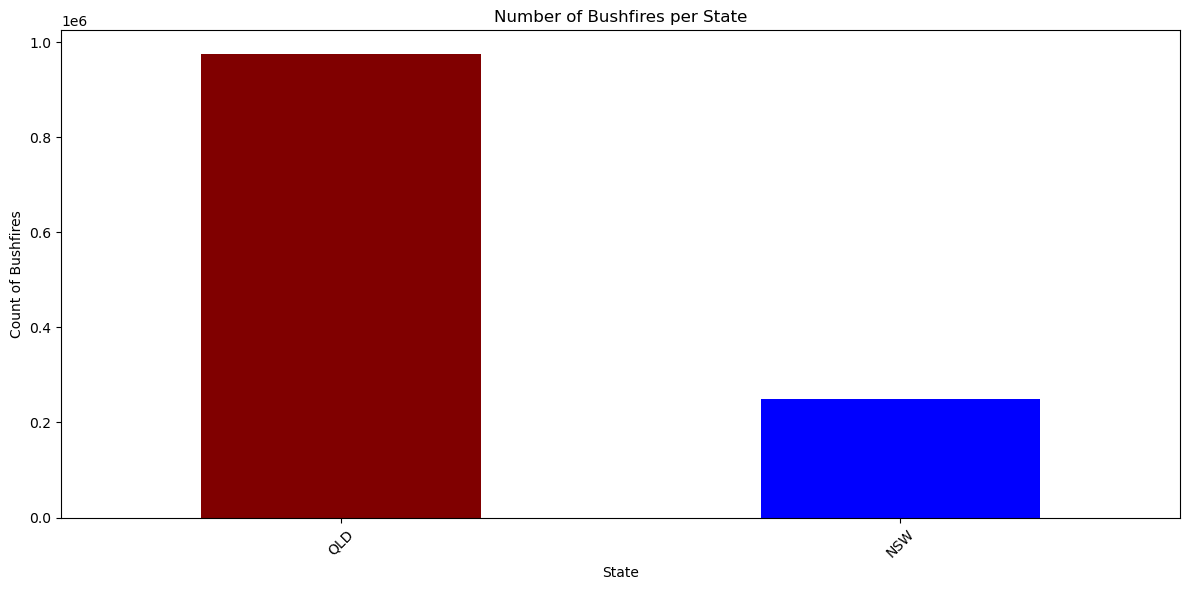

In [18]:
# Which State has more bushfires?

state_counts = final_merged_df[final_merged_df['bushfire_y_n'] == 1]['state'].value_counts()

# Create a color map for the states
colors = ['maroon' if state == 'QLD' else 'blue' if state == 'NSW' else 'skyblue' for state in state_counts.index]

# Plotting the results
plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar', color=colors)
plt.title('Number of Bushfires per State')
plt.xlabel('State')
plt.ylabel('Count of Bushfires')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# QLD by far!

Count of rows where bushfire_y_n is 'y': 1224416


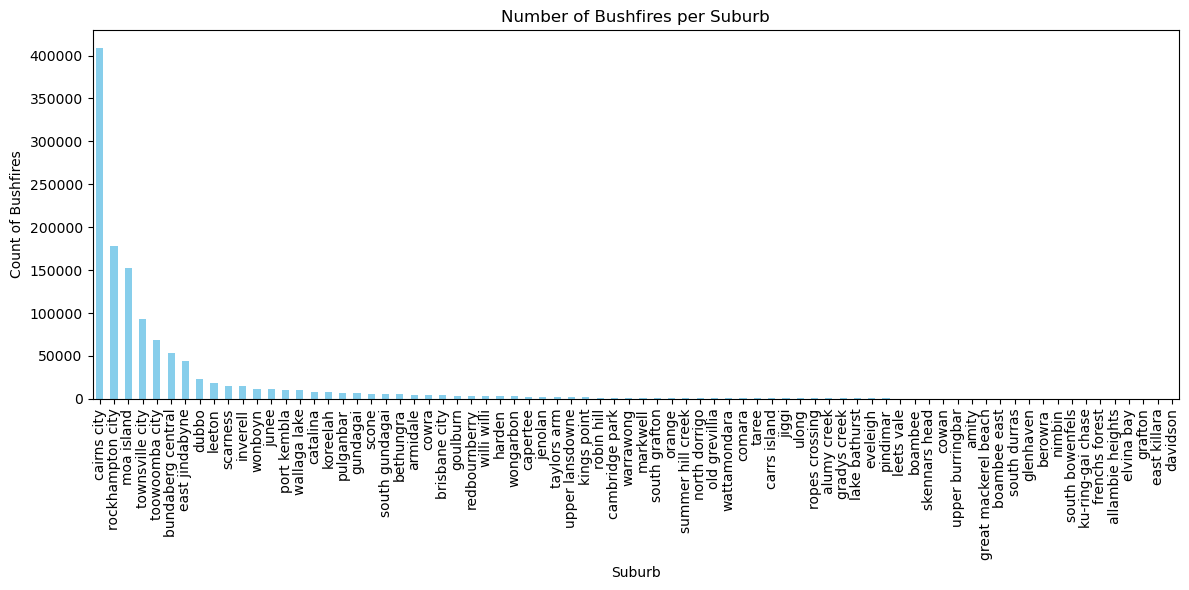

In [20]:
# Suburb

# Count occurrences of bushfire_y_n = 1
count_y = final_merged_df[final_merged_df['bushfire_y_n'] == 1].shape[0]
print(f"Count of rows where bushfire_y_n is 'y': {count_y}")

# Count the number of occurrences for each suburb where bushfire_y_n = 1
suburb_counts = final_merged_df[final_merged_df['bushfire_y_n'] == 1]['suburb'].value_counts()

# Plotting the results
if not suburb_counts.empty:
    plt.figure(figsize=(12, 6))
    suburb_counts.plot(kind='bar', color='skyblue')
    plt.title('Number of Bushfires per Suburb')
    plt.xlabel('Suburb')
    plt.ylabel('Count of Bushfires')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No suburbs found with bushfire_y_n = 'y'.")

In [21]:
# Poor old Cairns City
# Is there anything about the weather that could provide a clue?

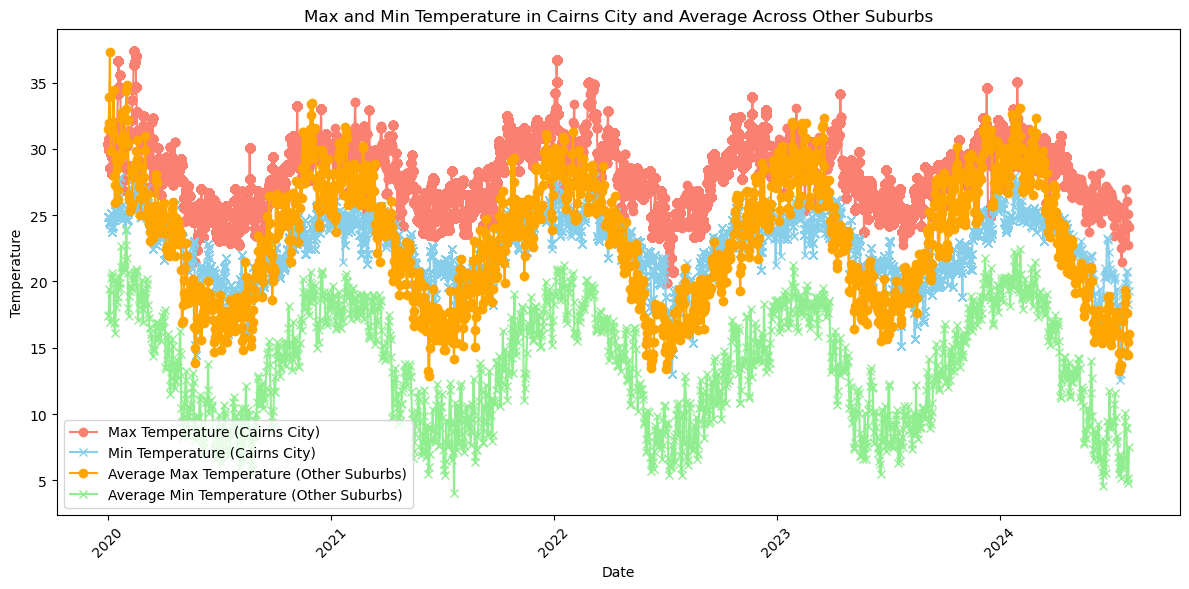

In [22]:
# Let's look at Temperature for Cairns
# Filter the DataFrame for Cairns City
cairns_data = final_merged_df[final_merged_df['suburb'] == 'cairns city'].copy()

# Ensure the date column is in datetime format
cairns_data['date'] = pd.to_datetime(cairns_data['date'])

# Sort Cairns data by date
cairns_data = cairns_data.sort_values(by='date')

# Calculate average MaxTemp and MinTemp across all suburbs excluding Cairns City
average_temp_data = final_merged_df[final_merged_df['suburb'] != 'cairns city'].copy()
average_temp_data['date'] = pd.to_datetime(average_temp_data['date'])

# Group by date and calculate the mean temperature
average_temp_data = average_temp_data.groupby('date').agg({'MaxTemp': 'mean', 'MinTemp': 'mean'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Plot for Cairns City
plt.plot(cairns_data['date'], cairns_data['MaxTemp'], marker='o', linestyle='-', color='salmon', label='Max Temperature (Cairns City)')
plt.plot(cairns_data['date'], cairns_data['MinTemp'], marker='x', linestyle='-', color='skyblue', label='Min Temperature (Cairns City)')

# Plot for average across other suburbs
plt.plot(average_temp_data['date'], average_temp_data['MaxTemp'], marker='o', linestyle='-', color='orange', label='Average Max Temperature (Other Suburbs)')
plt.plot(average_temp_data['date'], average_temp_data['MinTemp'], marker='x', linestyle='-', color='lightgreen', label='Average Min Temperature (Other Suburbs)')

# Adding titles and labels
plt.title('Max and Min Temperature in Cairns City and Average Across Other Suburbs')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Above average temperatures (no surprise given its location)

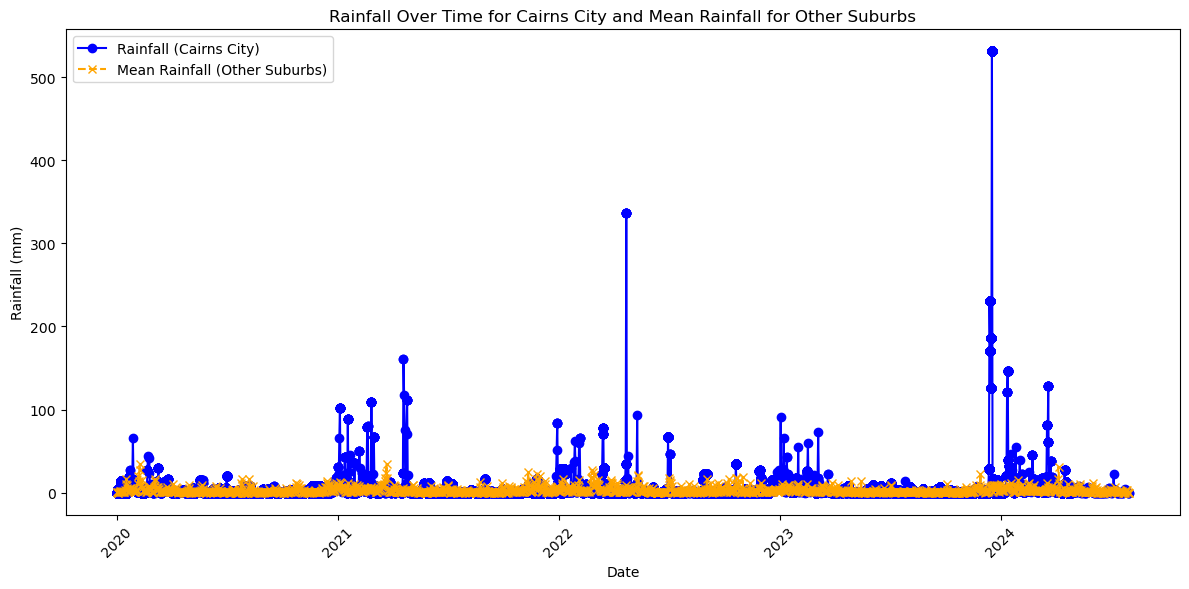

In [24]:
# Rainfall for Cairns City

# Filter the DataFrame for Cairns City
cairns_data = final_merged_df[final_merged_df['suburb'] == 'cairns city'].copy()
cairns_data.loc[:, 'date'] = pd.to_datetime(cairns_data['date'])  # Ensure date is datetime
cairns_data = cairns_data.sort_values(by='date')

# Calculate mean rainfall for all other suburbs
other_suburbs_data = final_merged_df[final_merged_df['suburb'] != 'cairns city']
mean_rainfall = other_suburbs_data.groupby('date')['RainSum'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Plot Cairns City's RainSum
plt.plot(cairns_data['date'], cairns_data['RainSum'], marker='o', linestyle='-', color='blue', label='Rainfall (Cairns City)')

# Plot mean rainfall for other suburbs
plt.plot(mean_rainfall['date'], mean_rainfall['RainSum'], marker='x', linestyle='--', color='orange', label='Mean Rainfall (Other Suburbs)')

# Adding titles and labels
plt.title('Rainfall Over Time for Cairns City and Mean Rainfall for Other Suburbs')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# A few tropical storms by the look of it (again known weather pattern for North QLD)

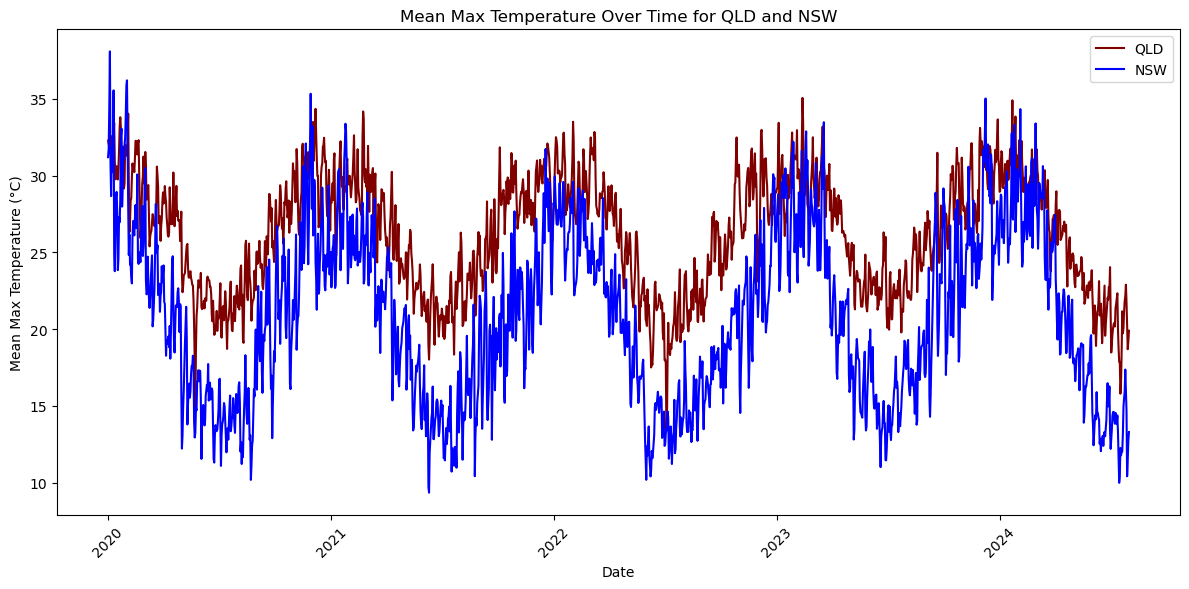

In [26]:
# Maximum Temperatures per State
# Filter for QLD and NSW
qld_data = final_merged_df[final_merged_df['state'] == 'QLD']
nsw_data = final_merged_df[final_merged_df['state'] == 'NSW']

# Group by date and calculate mean MaxTemp for each state
mean_max_temp_qld = qld_data.groupby('date')['MaxTemp'].mean().reset_index()
mean_max_temp_nsw = nsw_data.groupby('date')['MaxTemp'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(mean_max_temp_qld['date'], mean_max_temp_qld['MaxTemp'], label='QLD', color='maroon')
plt.plot(mean_max_temp_nsw['date'], mean_max_temp_nsw['MaxTemp'], label='NSW', color='blue')

plt.title('Mean Max Temperature Over Time for QLD and NSW')
plt.xlabel('Date')
plt.ylabel('Mean Max Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


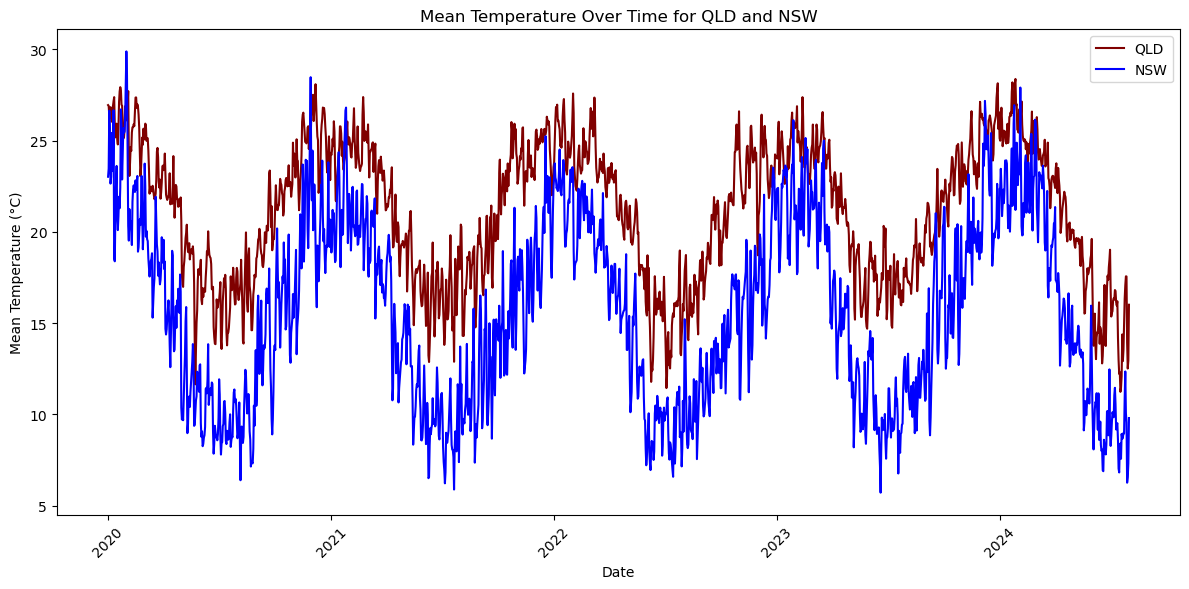

In [27]:
# Mean Temperatures per State

# Filter for QLD and NSW
qld_data = final_merged_df[final_merged_df['state'] == 'QLD']
nsw_data = final_merged_df[final_merged_df['state'] == 'NSW']

# Group by date and calculate mean MaxTemp for each state
mean_mean_temp_qld = qld_data.groupby('date')['MeanTemp'].mean().reset_index()
mean_mean_temp_nsw = nsw_data.groupby('date')['MeanTemp'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(mean_mean_temp_qld['date'], mean_mean_temp_qld['MeanTemp'], label='QLD', color='maroon')
plt.plot(mean_mean_temp_qld['date'], mean_mean_temp_nsw['MeanTemp'], label='NSW', color='blue')

plt.title('Mean Temperature Over Time for QLD and NSW')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

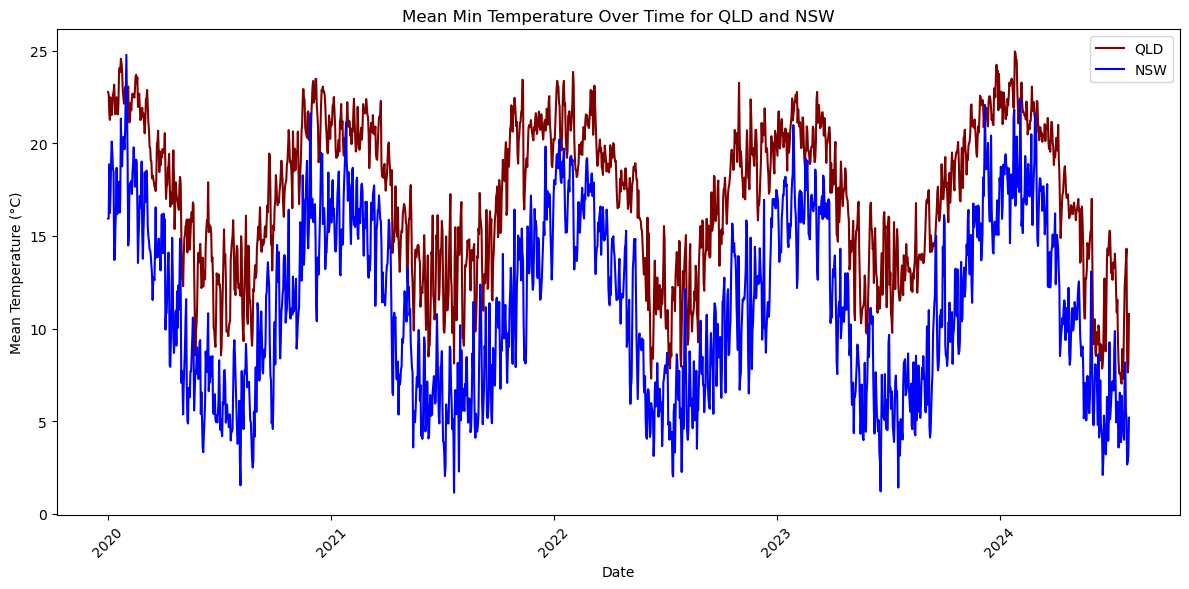

In [28]:
# Minumum Temperatures per State

# Filter for QLD and NSW
qld_data = final_merged_df[final_merged_df['state'] == 'QLD']
nsw_data = final_merged_df[final_merged_df['state'] == 'NSW']

# Group by date and calculate mean MaxTemp for each state
mean_min_temp_qld = qld_data.groupby('date')['MinTemp'].mean().reset_index()
mean_min_temp_nsw = nsw_data.groupby('date')['MinTemp'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(mean_min_temp_qld['date'], mean_min_temp_qld['MinTemp'], label='QLD', color='maroon')
plt.plot(mean_min_temp_qld['date'], mean_min_temp_nsw['MinTemp'], label='NSW', color='blue')

plt.title('Mean Min Temperature Over Time for QLD and NSW')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
# No surprises with the temperature data....QLD is generally warmer than NSW ;-)

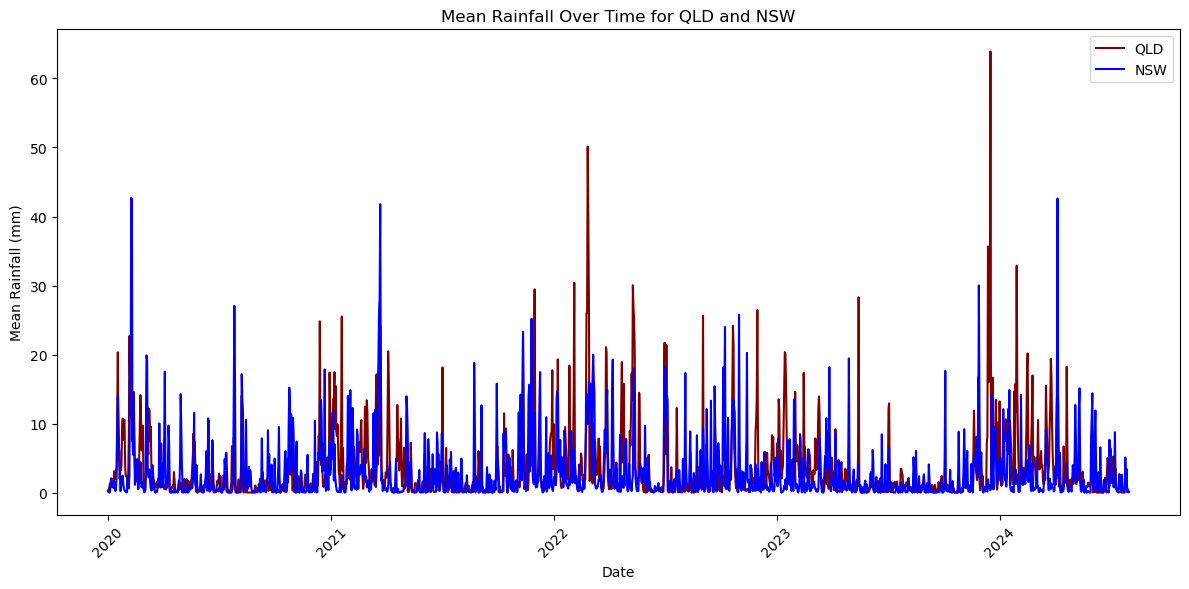

In [30]:
# Rainfall average per State

# Filter for QLD and NSW
qld_data = final_merged_df[final_merged_df['state'] == 'QLD']
nsw_data = final_merged_df[final_merged_df['state'] == 'NSW']

# Group by date and calculate mean RainSum for each state
mean_rain_sum_qld = qld_data.groupby('date')['RainSum'].mean().reset_index()
mean_rain_sum_nsw = nsw_data.groupby('date')['RainSum'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(mean_rain_sum_qld['date'], mean_rain_sum_qld['RainSum'], label='QLD', color='maroon')
plt.plot(mean_rain_sum_nsw['date'], mean_rain_sum_nsw['RainSum'], label='NSW', color='blue')

plt.title('Mean Rainfall Over Time for QLD and NSW')
plt.xlabel('Date')
plt.ylabel('Mean Rainfall (mm)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

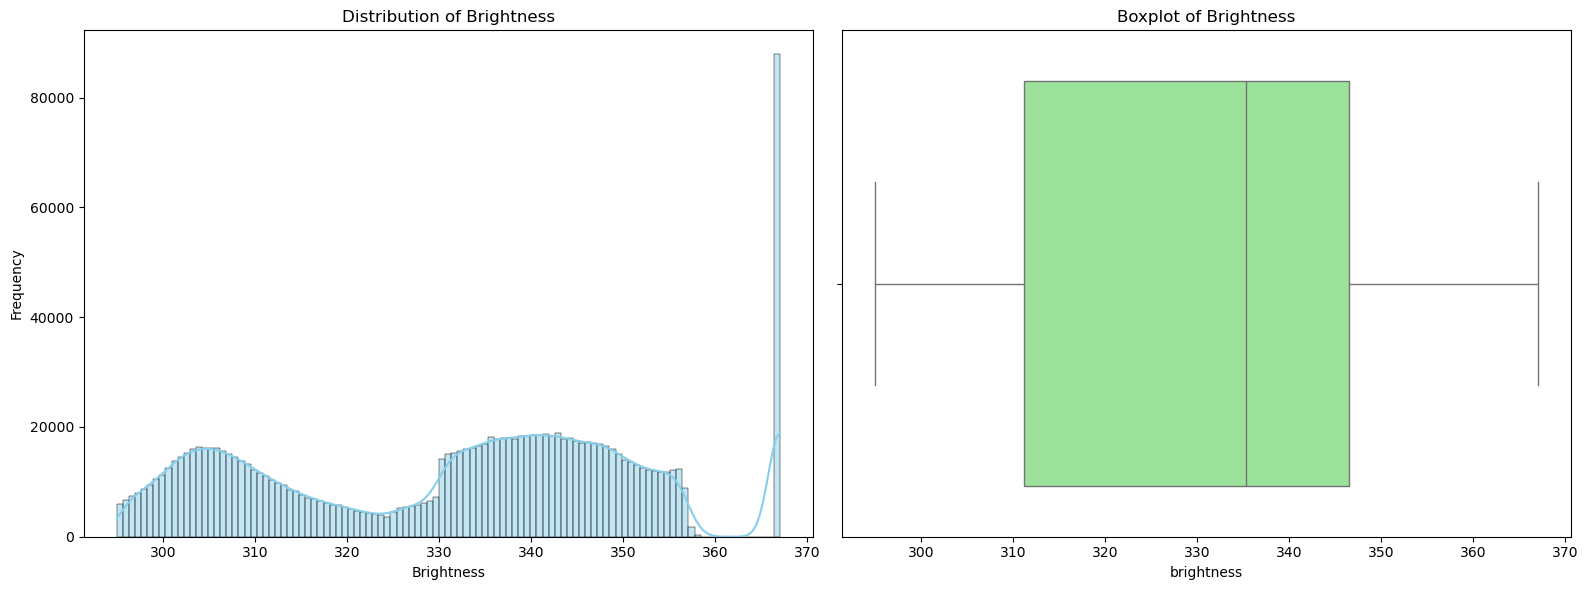

In [31]:
# Brightness

# Drop NaN values
brightness_data = final_merged_df['brightness'].dropna()

# Create a figure and a grid of subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting histplot using seaborn
sns.histplot(final_merged_df['brightness'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_xlabel('Brightness')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Brightness')

# Plotting boxplot using seaborn
sns.boxplot(data=final_merged_df, x='brightness', ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot of Brightness')

plt.tight_layout()  # Ensure plots are neatly arranged
plt.show()

In [32]:
# No outliers

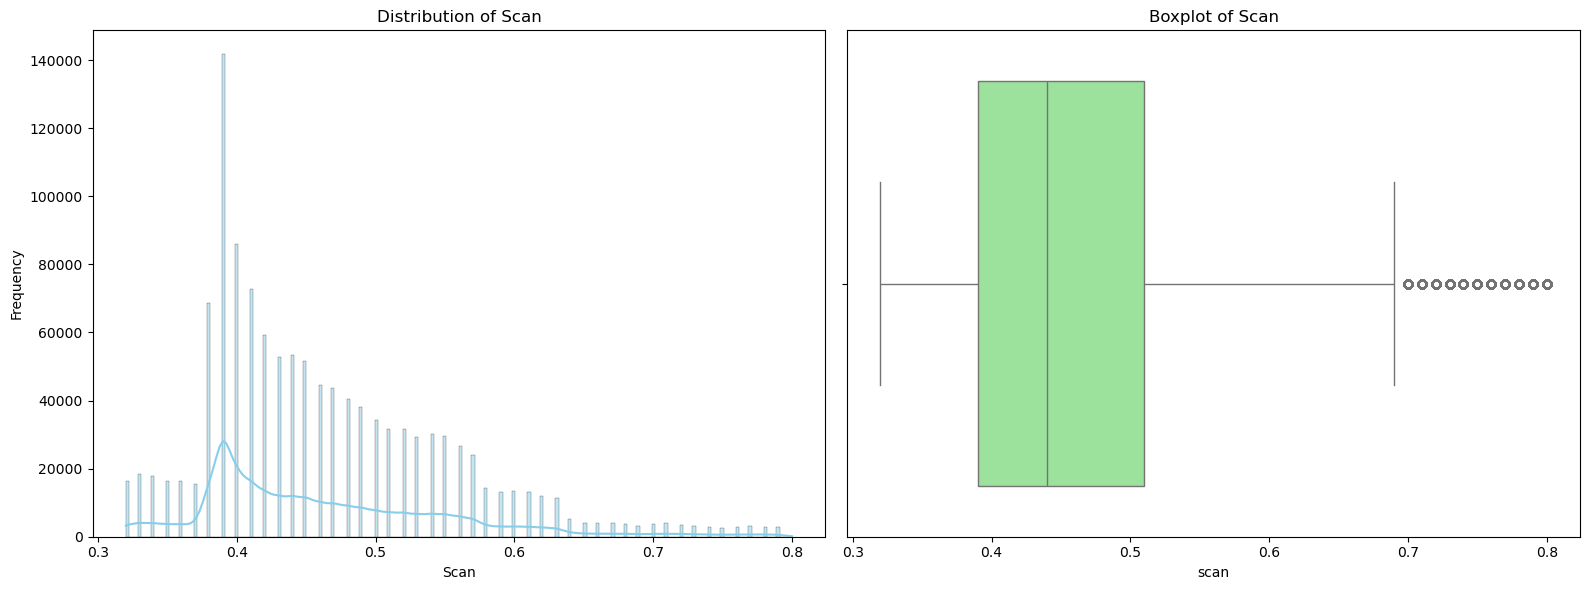

In [33]:
# Scan

# Drop NaN values
scan_data = final_merged_df['scan'].dropna()

# Create a figure and a grid of subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting histplot using seaborn
sns.histplot(final_merged_df['scan'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_xlabel('Scan')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Scan')

# Plotting boxplot using seaborn
sns.boxplot(data=final_merged_df, x='scan', ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot of Scan')

plt.tight_layout() 
plt.show()

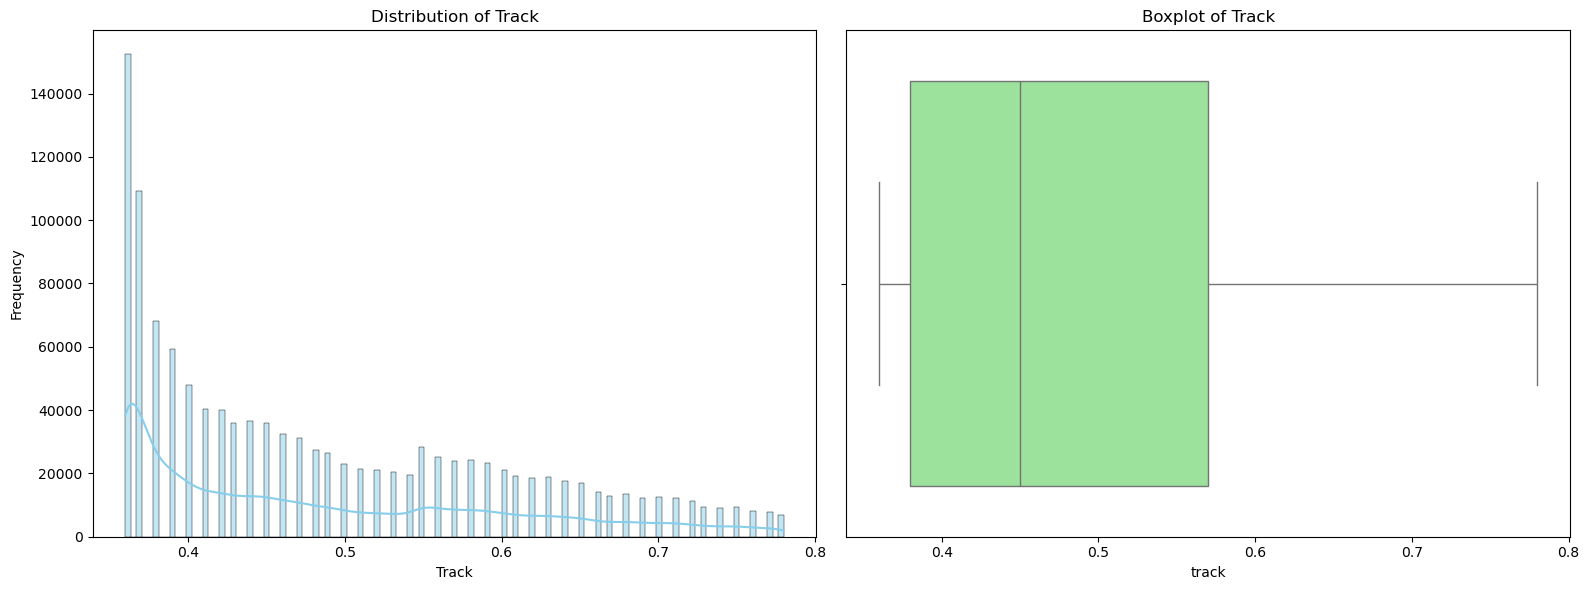

In [34]:
# Track

# Drop NaN values
track_data = final_merged_df['track'].dropna()

# Create a figure and a grid of subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting histplot using seaborn
sns.histplot(final_merged_df['track'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_xlabel('Track')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Track')

# Plotting boxplot using seaborn
sns.boxplot(data=final_merged_df, x='track', ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot of Track')

plt.tight_layout() 
plt.show()

In [35]:
# Quite similar to scan

In [36]:
# acq_time

# Convert acq_time to string, drop the decimal, and zero-fill to 4 digits
final_merged_df['acq_time'] = final_merged_df['acq_time'].astype(str).str.replace('.0', '').str.zfill(4)
final_merged_df.head().T

,0,1,2,3,4
suburb,aarons pass,aarons pass,aarons pass,aarons pass,aarons pass
state,NSW,NSW,NSW,NSW,NSW
MeanTemp,18.106417,19.798082,24.583502,25.281418,15.487667
MaxTemp,30.471,31.671001,36.521,40.121002,23.071001
MinTemp,8.771,11.521,17.071001,14.370999,11.471
RainSum,0.0,0.0,0.0,0.0,0.0
date,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-04 00:00:00,2020-01-05 00:00:00
brightness,NaN,NaN,NaN,NaN,NaN
scan,NaN,NaN,NaN,NaN,NaN
track,NaN,NaN,NaN,NaN,NaN


In [37]:
# Convert to time format only for non-NaN values
final_merged_df['acq_time'] = pd.to_datetime(final_merged_df['acq_time'], format='%H%M', errors='coerce').dt.time
final_merged_df.head()

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,date,brightness,scan,track,acq_time,confidence,bright_t31,frp,daynight,type,area,bf_area,bf_area_pct,bushfire_y_n
0,aarons pass,NSW,18.106417,30.471000,8.771000,0.0,2020-01-01,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,82.838001,82.836363,0.99998,0
1,aarons pass,NSW,19.798082,31.671001,11.521000,0.0,2020-01-02,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,82.838001,82.836363,0.99998,0
2,aarons pass,NSW,24.583502,36.521000,17.071001,0.0,2020-01-03,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,82.838001,82.836363,0.99998,0
3,aarons pass,NSW,25.281418,40.121002,14.370999,0.0,2020-01-04,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,82.838001,82.836363,0.99998,0
4,aarons pass,NSW,15.487667,23.071001,11.471000,0.0,2020-01-05,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,82.838001,82.836363,0.99998,0


In [38]:
# Check for Allambie
result = final_merged_df[(final_merged_df['suburb'] == 'allambie heights') & 
                          (final_merged_df['date'] == '2021-08-22')]
print(result)

                  suburb state  MeanTemp    MaxTemp  MinTemp  RainSum  \
116105  allambie heights   NSW    18.104  24.629002   13.479      0.0   

             date  brightness  scan  track  acq_time  confidence  bright_t31  \
116105 2021-08-22       342.1  0.36   0.57  04:27:00         1.0      294.91   

         frp  daynight  type      area   bf_area  bf_area_pct  bushfire_y_n  
116105  4.61       0.0   0.0  6.694738  5.190644     0.775332             1  


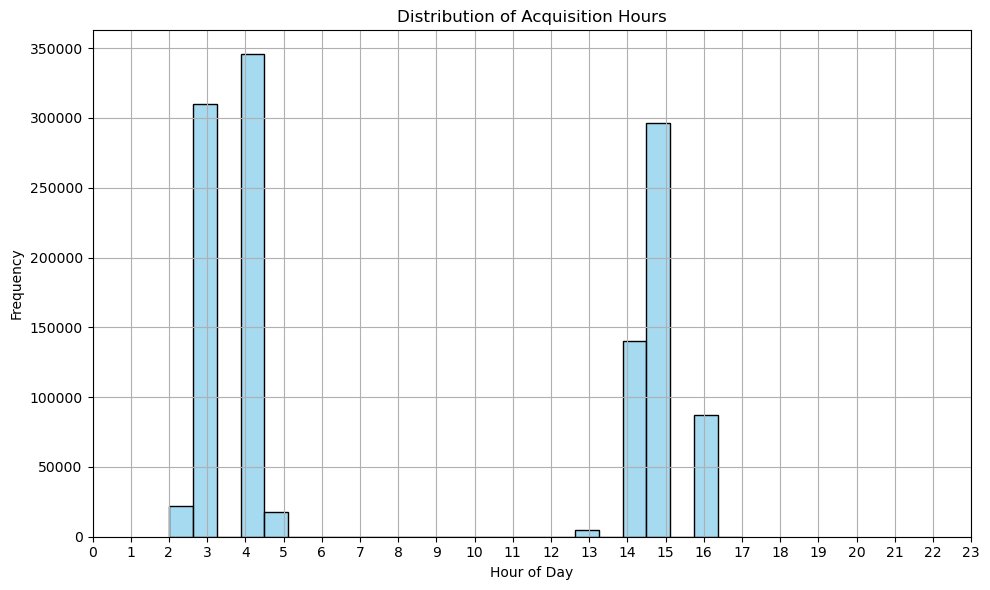

In [39]:
# It worked, converted correctly so now I should be able to plot the hours

# Convert acq_time to datetime
final_merged_df['acq_time'] = pd.to_datetime(final_merged_df['acq_time'], format='%H:%M:%S', errors='coerce')

# Extract hour
final_merged_df['hour'] = final_merged_df['acq_time'].dt.hour

# Drop NaN values
hour_data = final_merged_df['hour'].dropna()

# Check if there is data to plot
if hour_data.empty:
    print("No valid hour data to plot.")
else:
    # Plotting Histogram of Acquisition Hours
    plt.figure(figsize=(10, 6))
    sns.histplot(hour_data, bins=24, color='skyblue', kde=False)

    # Adding titles and labels
    plt.title('Distribution of Acquisition Hours')
    plt.xlabel('Hour of Day')
    plt.ylabel('Frequency')
    plt.xticks(range(24))  # Show hours from 0 to 23
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [40]:
# Seems there are 2 main acquisition periods...probably as the satellite passes overhead

In [41]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14232351 entries, 0 to 14232350
Data columns (total 21 columns):
 #   Column        Dtype         
---  ------        -----         
 0   suburb        object        
 1   state         object        
 2   MeanTemp      float64       
 3   MaxTemp       float64       
 4   MinTemp       float64       
 5   RainSum       float64       
 6   date          datetime64[ns]
 7   brightness    float64       
 8   scan          float64       
 9   track         float64       
 10  acq_time      datetime64[ns]
 11  confidence    float64       
 12  bright_t31    float64       
 13  frp           float64       
 14  daynight      float64       
 15  type          float64       
 16  area          float64       
 17  bf_area       float64       
 18  bf_area_pct   float64       
 19  bushfire_y_n  int32         
 20  hour          float64       
dtypes: datetime64[ns](2), float64(16), int32(1), object(2)
memory usage: 2.2+ GB


In [42]:
# Will likely need to handle the NaNs before modelling

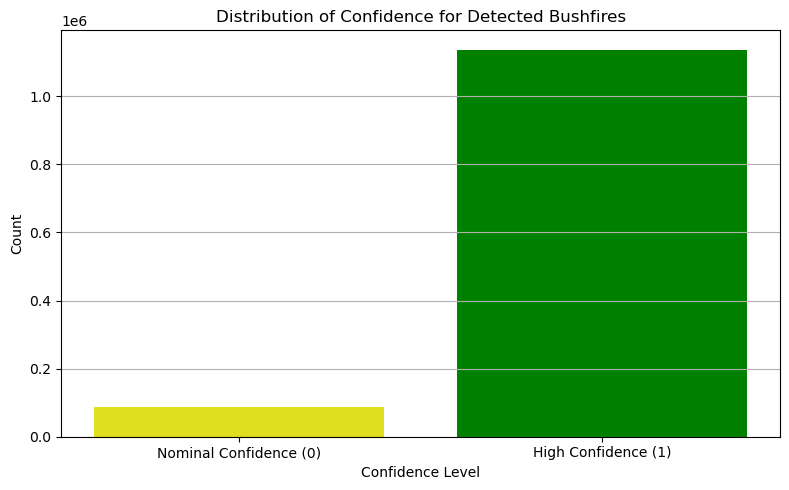

In [43]:
# Confidence

# Count confidence values where bushfire was detected
confidence_counts = final_merged_df[final_merged_df['bushfire_y_n'] == 1]['confidence'].value_counts()

# Create a DataFrame for seaborn
confidence_df = pd.DataFrame({'Confidence': confidence_counts.index, 'Count': confidence_counts.values})

# Plotting the confidence distribution
plt.figure(figsize=(8, 5))

# Create the bar plot with the specified colors
sns.barplot(x='Confidence', y='Count', data=confidence_df,
            color='yellow' if 0 in confidence_df['Confidence'].values else 'green')

# Manually add the second bar for high confidence
plt.bar(1, confidence_df['Count'][confidence_df['Confidence'] == 1].values[0], color='green')

# Adding titles and labels
plt.title('Distribution of Confidence for Detected Bushfires')
plt.xlabel('Confidence Level')
plt.ylabel('Count')
plt.xticks([0, 1], ['Nominal Confidence (0)', 'High Confidence (1)'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [44]:
# A lot of high confidence

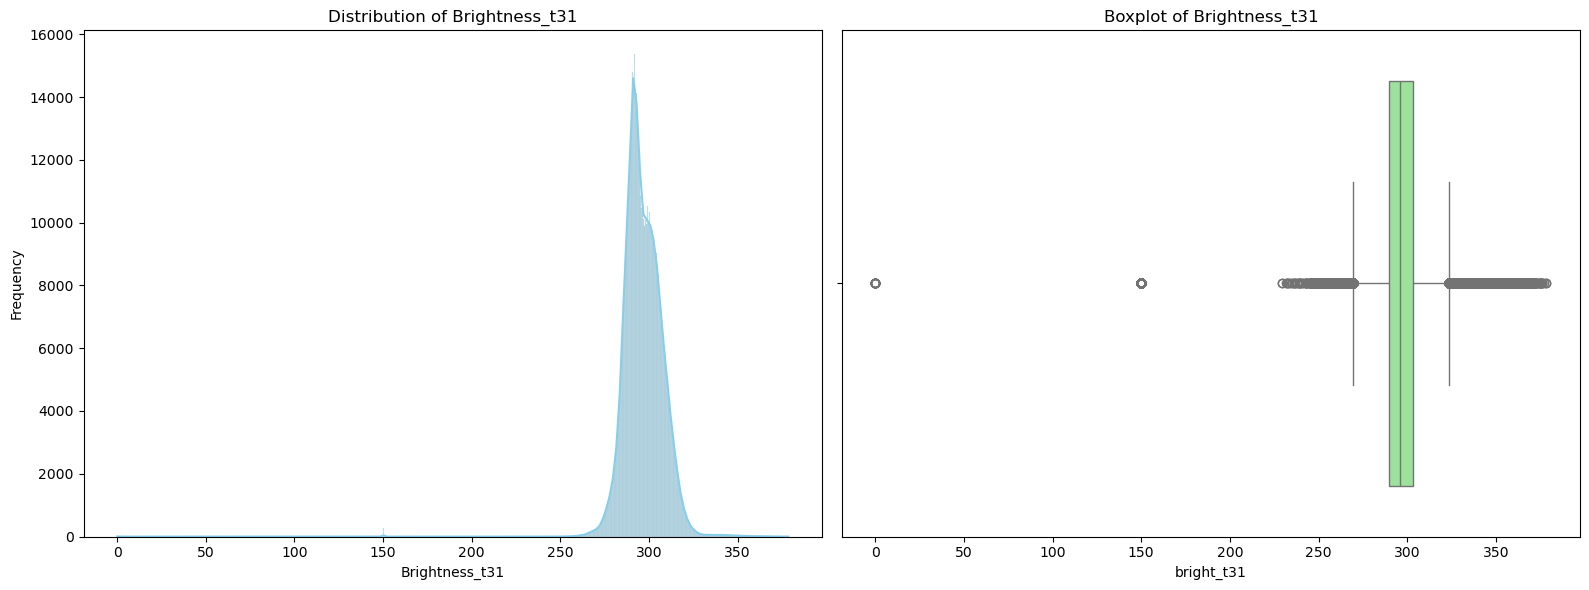

In [45]:
# Brightness t31

# Drop NaN values
brightnesst31_data = final_merged_df['bright_t31'].dropna()

# Create a figure and a grid of subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting histplot using seaborn
sns.histplot(final_merged_df['bright_t31'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_xlabel('Brightness_t31')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Brightness_t31')

# Plotting boxplot using seaborn
sns.boxplot(data=final_merged_df, x='bright_t31', ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot of Brightness_t31')

plt.tight_layout()  # Ensure plots are neatly arranged
plt.show()

In [46]:
# A couple of anomalies / outliers but otherwise fairly normally distributed

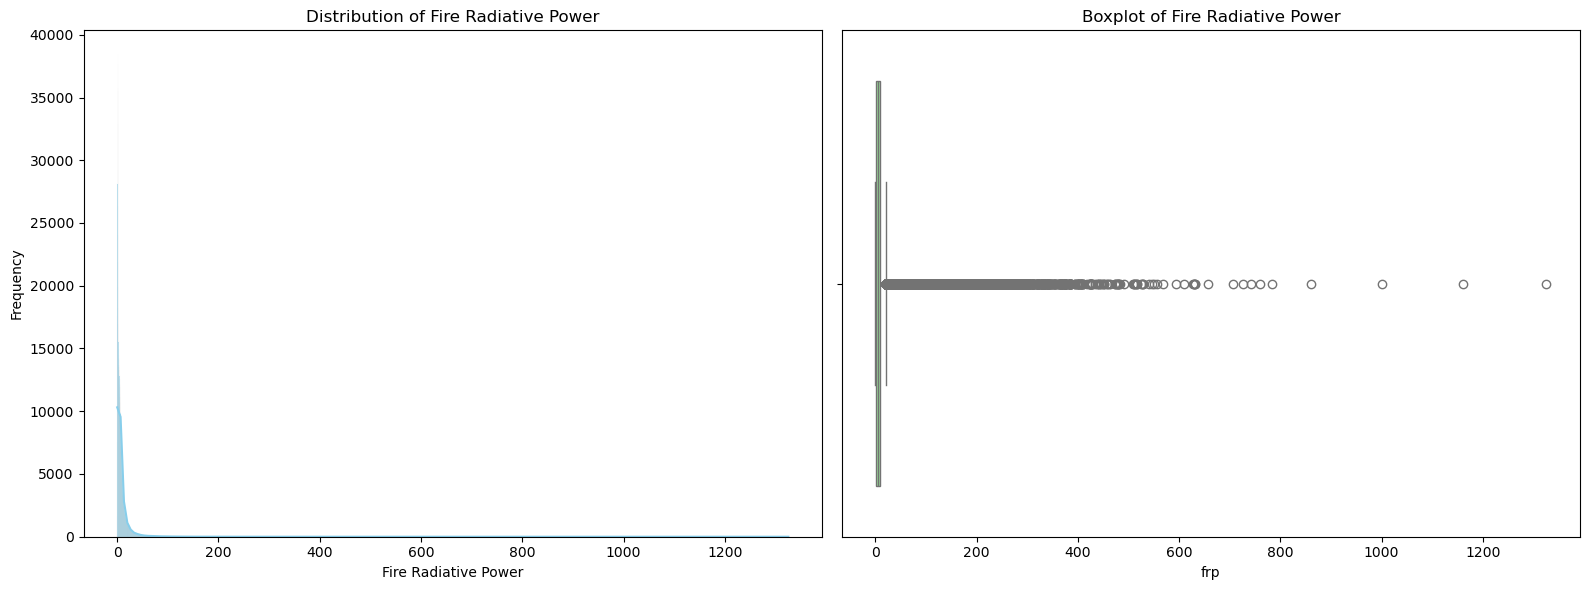

In [47]:
# frp

# Drop NaN values
frp_data = final_merged_df['frp'].dropna()

# Create a figure and a grid of subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting histplot using seaborn
sns.histplot(final_merged_df['frp'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_xlabel('Fire Radiative Power')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Fire Radiative Power')

# Plotting boxplot using seaborn
sns.boxplot(data=final_merged_df, x='frp', ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot of Fire Radiative Power')

plt.tight_layout()
plt.show()

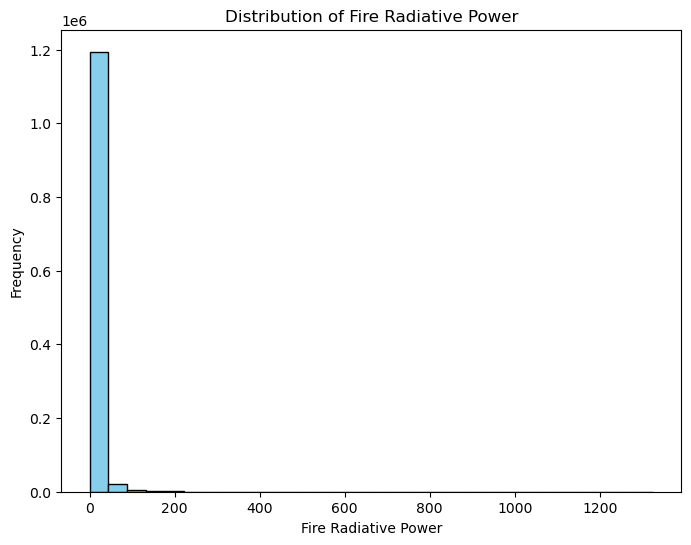

In [48]:
# Plotting histogram separately as data was concentrated in one small part of the chart and it was difficult to read

# Drop NaN values
frp_data = final_merged_df['frp'].dropna()

plt.figure(figsize=(8, 6))
plt.hist(final_merged_df['frp'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Fire Radiative Power')
plt.ylabel('Frequency')
plt.title('Distribution of Fire Radiative Power')
plt.show()

In [49]:
# Most fires emit low FRP, but there are some anomalies
# Quite skewed

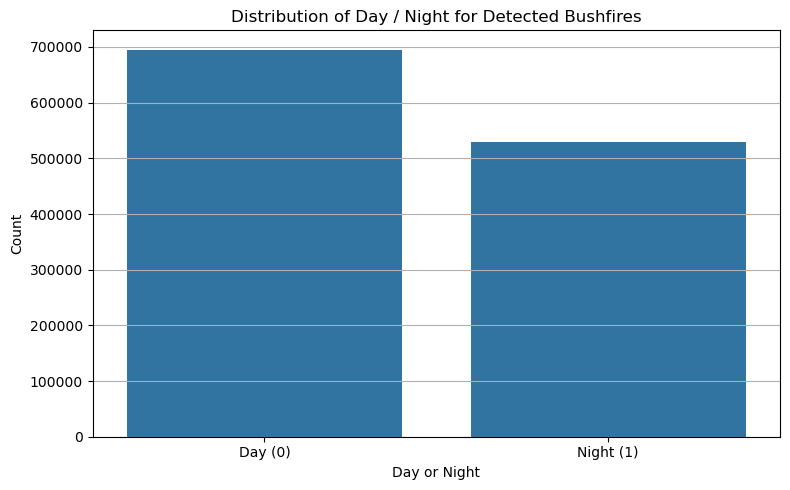

In [50]:
# Daynight

# Count daynight values where bushfire was detected (# 0=D, 1=N)
daynight_counts = final_merged_df[final_merged_df['bushfire_y_n'] == 1]['daynight'].value_counts()

# Plotting the confidence distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=daynight_counts.index, y=daynight_counts.values)

# Adding titles and labels
plt.title('Distribution of Day / Night for Detected Bushfires')
plt.xlabel('Day or Night')
plt.ylabel('Count')
plt.xticks([0, 1], ['Day (0)', 'Night (1)']) 
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [51]:
# Roughly evenly split

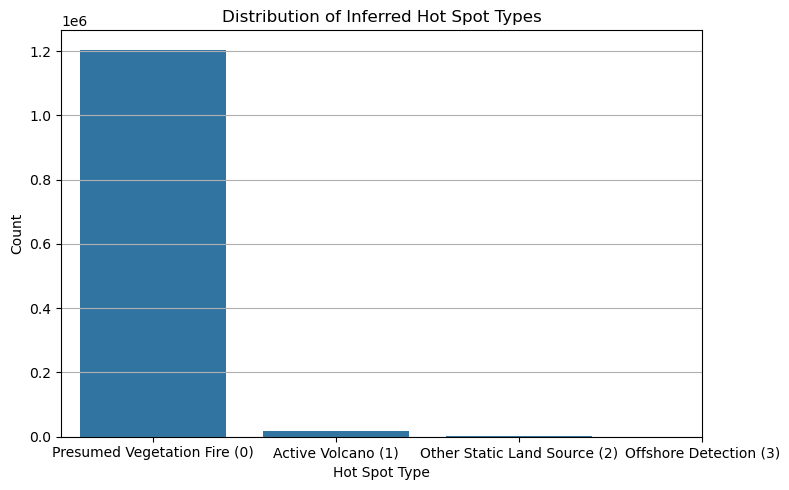

In [52]:
# Type

# Count occurrences of each hot spot type
hotspot_counts = final_merged_df['type'].value_counts()

# Plotting the hotspot type distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=hotspot_counts.index, y=hotspot_counts.values)

# Adding titles and labels
plt.title('Distribution of Inferred Hot Spot Types')
plt.xlabel('Hot Spot Type')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3], 
           ['Presumed Vegetation Fire (0)', 
            'Active Volcano (1)', 
            'Other Static Land Source (2)', 
            'Offshore Detection (3)']) 
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [53]:
# Find rows where hotspot_type = 1
active_volcano_rows = final_merged_df[final_merged_df['type'] == 1]

# Display the results
print(active_volcano_rows)

Empty DataFrame
Columns: [suburb, state, MeanTemp, MaxTemp, MinTemp, RainSum, date, brightness, scan, track, acq_time, confidence, bright_t31, frp, daynight, type, area, bf_area, bf_area_pct, bushfire_y_n, hour]
Index: []

[0 rows x 21 columns]


In [54]:
# I don't understand how I can have an active volcano if there is no type 1 in the df!

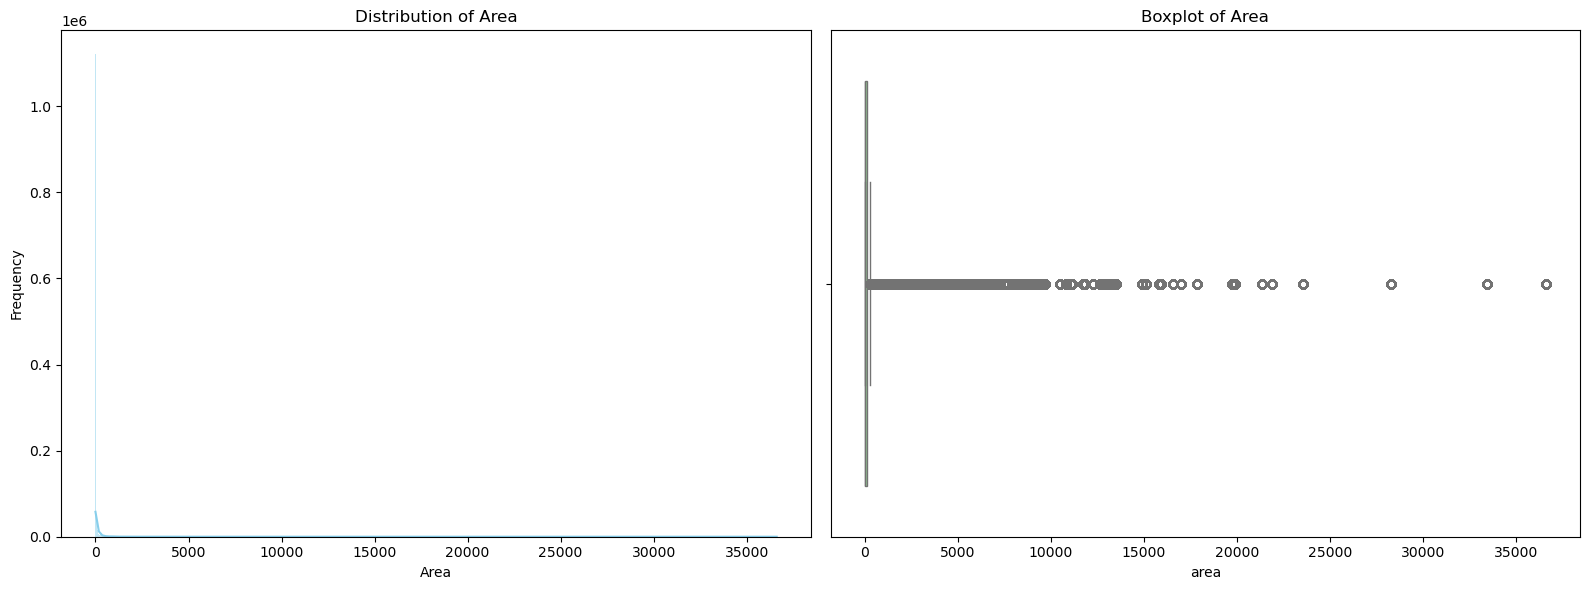

In [55]:
# Area

# Drop NaN values
area_data = final_merged_df['area'].dropna()

# Create a figure and a grid of subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting histplot using seaborn
sns.histplot(final_merged_df['area'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_xlabel('Area')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Area')

# Plotting boxplot using seaborn
sns.boxplot(data=final_merged_df, x='area', ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot of Area')

plt.tight_layout()
plt.show()

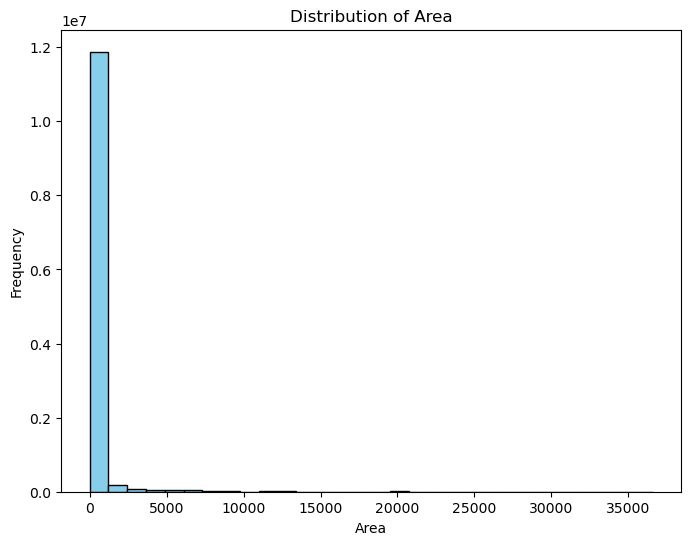

In [56]:
# Plotting histogram separately as data was concentrated in one small part of the chart

# Drop NaN values
area_data = final_merged_df['area'].dropna()

plt.figure(figsize=(8, 6))
plt.hist(final_merged_df['area'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Distribution of Area')
plt.show()

In [57]:
# Most are smaller areas but some are very large
# Quite skewed

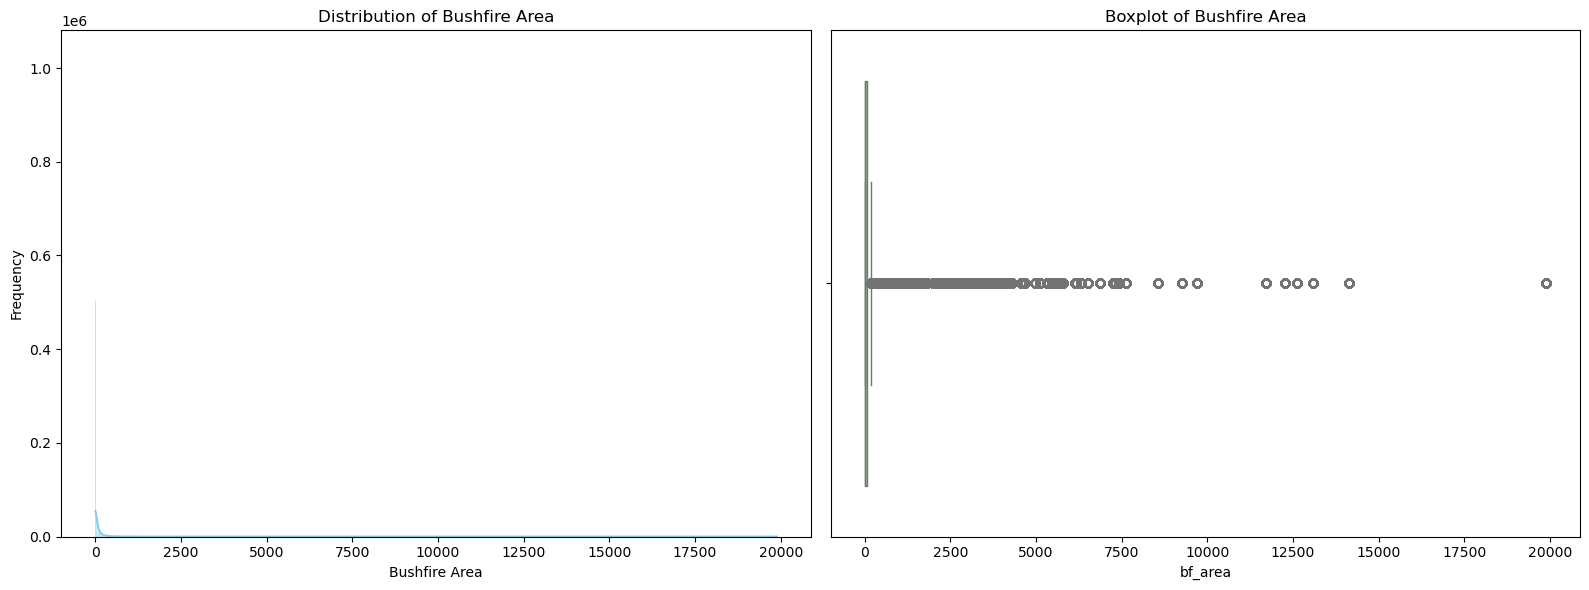

In [58]:
# Bushfire Area

# Drop NaN values
busharea_data = final_merged_df['bf_area'].dropna()

# Create a figure and a grid of subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting histplot using seaborn
sns.histplot(final_merged_df['bf_area'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_xlabel('Bushfire Area')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Bushfire Area')

# Plotting boxplot using seaborn
sns.boxplot(data=final_merged_df, x='bf_area', ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot of Bushfire Area')

plt.tight_layout()
plt.show()

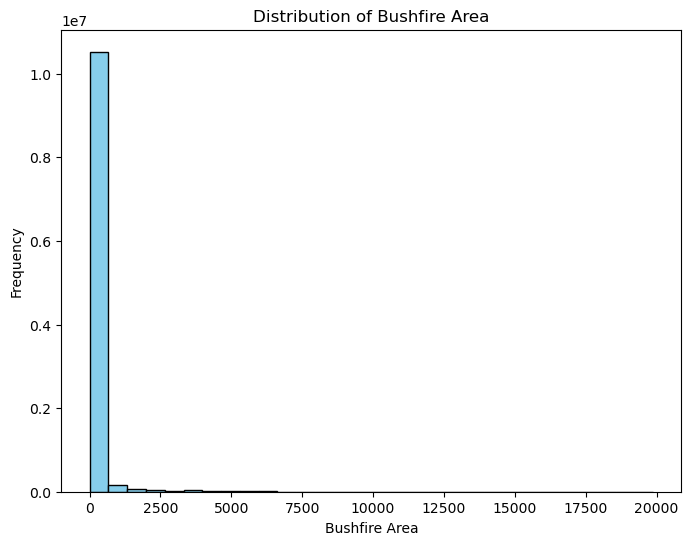

In [59]:
# Plotting histogram separately as data was concentrated in one small part of the chart

# Drop NaN values
busharea_data = final_merged_df['bf_area'].dropna()

plt.figure(figsize=(8, 6))
plt.hist(final_merged_df['bf_area'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Bushfire Area')
plt.ylabel('Frequency')
plt.title('Distribution of Bushfire Area')
plt.show()

In [60]:
# Most are smaller areas but some are very large
# Quite skewed

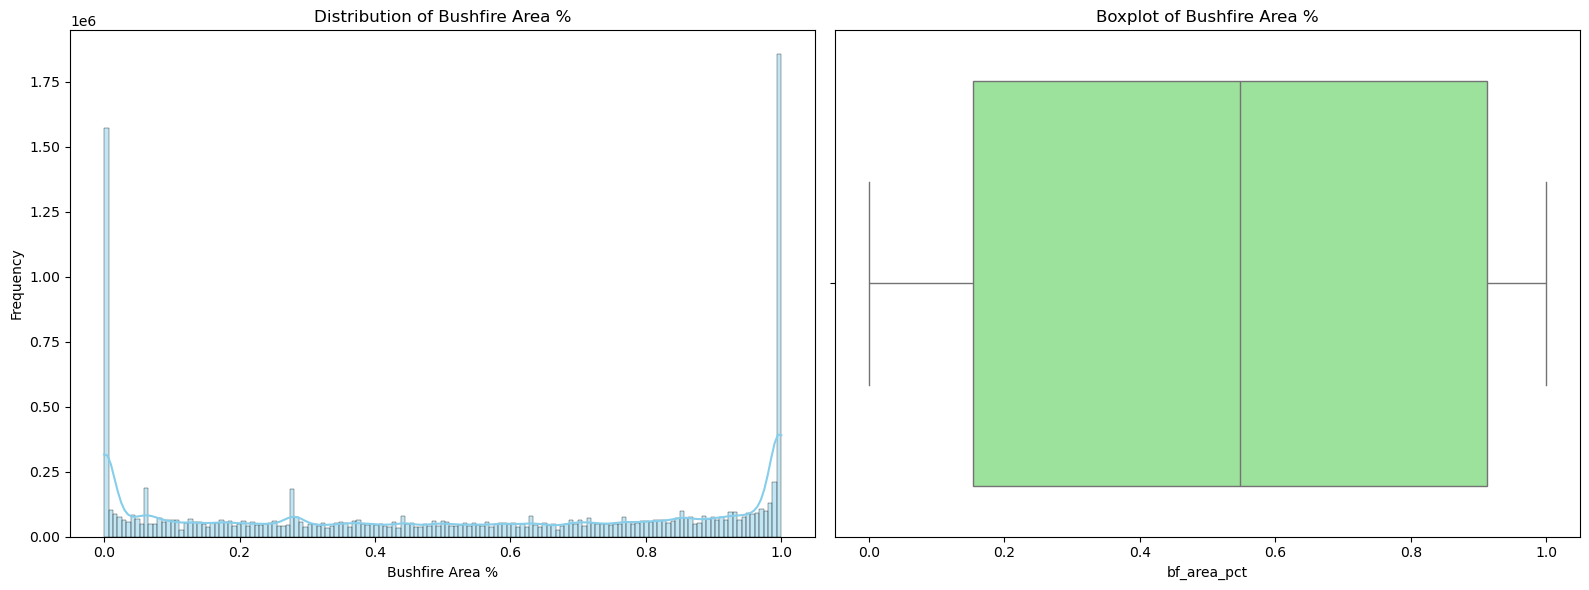

In [61]:
# Bushfire Area %

# Drop NaN values
areapct_data = final_merged_df['bf_area_pct'].dropna()

# Create a figure and a grid of subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting histplot using seaborn
sns.histplot(final_merged_df['bf_area_pct'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_xlabel('Bushfire Area %')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Bushfire Area %')

# Plotting boxplot using seaborn
sns.boxplot(data=final_merged_df, x='bf_area_pct', ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot of Bushfire Area %')

plt.tight_layout()
plt.show()

In [62]:
# Some areas where it's really low and some really high

## Data Preprocessing

In [64]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14232351 entries, 0 to 14232350
Data columns (total 21 columns):
 #   Column        Dtype         
---  ------        -----         
 0   suburb        object        
 1   state         object        
 2   MeanTemp      float64       
 3   MaxTemp       float64       
 4   MinTemp       float64       
 5   RainSum       float64       
 6   date          datetime64[ns]
 7   brightness    float64       
 8   scan          float64       
 9   track         float64       
 10  acq_time      datetime64[ns]
 11  confidence    float64       
 12  bright_t31    float64       
 13  frp           float64       
 14  daynight      float64       
 15  type          float64       
 16  area          float64       
 17  bf_area       float64       
 18  bf_area_pct   float64       
 19  bushfire_y_n  int32         
 20  hour          float64       
dtypes: datetime64[ns](2), float64(16), int32(1), object(2)
memory usage: 2.2+ GB


In [65]:
# Suburb and State will need to be encoded
# Encode suburb and state
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder_suburb = LabelEncoder()
label_encoder_state = LabelEncoder()

# Fit and transform the suburb column
final_merged_df['suburb_encoded'] = label_encoder_suburb.fit_transform(final_merged_df['suburb'])
final_merged_df['state_encoded'] = label_encoder_state.fit_transform(final_merged_df['state'])

# Display the updated DataFrame
final_merged_df.sample(6)

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,date,brightness,scan,track,...,frp,daynight,type,area,bf_area,bf_area_pct,bushfire_y_n,hour,suburb_encoded,state_encoded
10328446,queens pinch,NSW,10.237333,15.479000,6.379000,2.7,2022-06-20,NaN,NaN,NaN,...,NaN,NaN,NaN,44.566486,35.324289,0.792620,0,NaN,5674,0
12743393,tyalgum,NSW,18.284834,24.714000,13.764000,0.0,2023-04-27,NaN,NaN,NaN,...,NaN,NaN,NaN,31.088098,30.962323,0.995954,0,NaN,6892,0
243608,arana hills,QLD,17.089834,22.069000,12.568999,1.2,2020-06-16,NaN,NaN,NaN,...,NaN,NaN,NaN,3.683086,0.757230,0.205597,0,NaN,144,1
7103022,lake macdonald,QLD,20.143250,26.549500,15.249500,0.0,2020-04-12,NaN,NaN,NaN,...,NaN,NaN,NaN,26.882183,18.623321,0.692776,0,NaN,3868,1
12314589,tolga,QLD,23.389917,30.667000,18.417000,0.0,2020-10-21,NaN,NaN,NaN,...,NaN,NaN,NaN,85.262371,41.956926,0.492092,0,NaN,6732,1
9163302,nana glen,NSW,13.028500,17.828499,8.828500,0.7,2022-09-07,NaN,NaN,NaN,...,NaN,NaN,NaN,65.508329,65.414219,0.998563,0,NaN,4990,0


In [66]:
# Create the mapping dictionary
suburb_encoding_dict = dict(zip(label_encoder_suburb.classes_, range(len(label_encoder_suburb.classes_))))

In [67]:
state_encoding_dict = dict(zip(label_encoder_state.classes_, range(len(label_encoder_state.classes_))))

In [68]:
# How many rows do I have where bf_area_pct is empty?
nan_count = final_merged_df['bf_area_pct'].isnull().sum()
print(f'Number of NaNs in bf_area_pct: {nan_count}')

Number of NaNs in bf_area_pct: 1881576


In [69]:
# 1881576 / 14232351 = approx 13%
# This isn't too much so maybe I can drop the NaN rows for now
# I could look for the nearest suburbs around and impute the mean for the missing values (an option)
# In future, more research to find these values

In [70]:
# Drop rows where bf_area and df_area_pct is NaN
final_merged_df = final_merged_df.dropna(subset=['bf_area','bf_area_pct'])

# Reset the index
final_merged_df = final_merged_df.reset_index(drop=True)

In [71]:
final_merged_df.shape

(10943047, 23)

In [72]:
final_merged_df.isnull().sum()

suburb                   0
state                    0
MeanTemp                 0
MaxTemp                  0
MinTemp                  0
RainSum                  0
date                     0
brightness        10453109
scan              10453109
track             10453109
acq_time          10453109
confidence        10453109
bright_t31        10453109
frp               10453109
daynight          10453109
type              10453109
area                     0
bf_area                  0
bf_area_pct              0
bushfire_y_n             0
hour              10453109
suburb_encoded           0
state_encoded            0
dtype: int64

In [73]:
# I want to give the machine the date but it is in datetime format

# Extracting year and month from the date column
final_merged_df['year'] = final_merged_df['date'].dt.year
final_merged_df['month'] = final_merged_df['date'].dt.month

final_merged_df.sample(5)

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,date,brightness,scan,track,...,type,area,bf_area,bf_area_pct,bushfire_y_n,hour,suburb_encoded,state_encoded,year,month
4741240,jagungal wilderness,NSW,11.591084,13.276500,9.9765,38.5,2021-03-23,NaN,NaN,NaN,...,NaN,461.942009,461.942009,1.000000,0,NaN,3426,0,2021,3
10447264,winburndale,NSW,17.036667,20.494999,15.2950,13.7,2020-03-03,NaN,NaN,NaN,...,NaN,110.771401,110.771401,1.000000,0,NaN,7408,0,2020,3
9697480,twelve mile peg,NSW,11.129666,16.688000,8.1380,0.0,2020-07-18,NaN,NaN,NaN,...,NaN,78.358540,78.358540,1.000000,0,NaN,6885,0,2020,7
4068567,gordonbrook,QLD,20.382002,24.519500,16.5695,0.0,2021-01-10,NaN,NaN,NaN,...,NaN,198.599265,83.607263,0.420985,0,NaN,2929,1,2021,1
1616625,burrumbuttock,NSW,22.751585,29.837000,16.1870,9.1,2024-03-19,NaN,NaN,NaN,...,NaN,177.714876,17.302898,0.097363,0,NaN,1168,0,2024,3


In [74]:
# Delete the date column

final_merged_df = final_merged_df.drop(columns=['date'])

In [75]:
final_merged_df.sample(5)

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,brightness,scan,track,acq_time,...,type,area,bf_area,bf_area_pct,bushfire_y_n,hour,suburb_encoded,state_encoded,year,month
2727518,dalwogon,QLD,17.754583,23.7775,12.3775,0.0,NaN,NaN,NaN,NaT,...,NaN,159.351717,137.133529,0.860571,0,NaN,1989,1,2021,8
3209829,east maitland,NSW,19.889418,26.3665,14.1665,0.0,NaN,NaN,NaN,NaT,...,NaN,15.999810,8.760237,0.547521,0,NaN,2286,0,2021,4
4572574,hoskinstown,NSW,15.269917,20.0595,12.2095,0.8,NaN,NaN,NaN,NaT,...,NaN,81.217422,81.167583,0.999386,0,NaN,3309,0,2022,6
3305739,ellen grove,QLD,13.706500,20.9190,7.3190,0.0,NaN,NaN,NaN,NaT,...,NaN,3.422432,1.877768,0.548665,0,NaN,2360,1,2022,8
1068513,booerie creek,NSW,16.226250,20.9825,13.8325,16.1,NaN,NaN,NaN,NaT,...,NaN,12.834233,5.113026,0.398390,0,NaN,786,0,2022,4


In [76]:
# We can now drop the acq_time column as we have the 'hour' column
final_merged_df = final_merged_df.drop(columns=['acq_time'])
final_merged_df.head()

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,brightness,scan,track,confidence,...,type,area,bf_area,bf_area_pct,bushfire_y_n,hour,suburb_encoded,state_encoded,year,month
0,aarons pass,NSW,18.106417,30.471000,8.771000,0.0,NaN,NaN,NaN,NaN,...,NaN,82.838001,82.836363,0.99998,0,NaN,0,0,2020,1
1,aarons pass,NSW,19.798082,31.671001,11.521000,0.0,NaN,NaN,NaN,NaN,...,NaN,82.838001,82.836363,0.99998,0,NaN,0,0,2020,1
2,aarons pass,NSW,24.583502,36.521000,17.071001,0.0,NaN,NaN,NaN,NaN,...,NaN,82.838001,82.836363,0.99998,0,NaN,0,0,2020,1
3,aarons pass,NSW,25.281418,40.121002,14.370999,0.0,NaN,NaN,NaN,NaN,...,NaN,82.838001,82.836363,0.99998,0,NaN,0,0,2020,1
4,aarons pass,NSW,15.487667,23.071001,11.471000,0.0,NaN,NaN,NaN,NaN,...,NaN,82.838001,82.836363,0.99998,0,NaN,0,0,2020,1


In [77]:
# Any missing 'types' can be assumed to be 0 i.e. vegetation
final_merged_df['type'] = final_merged_df['type'].fillna(0).astype(int)

In [78]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10943047 entries, 0 to 10943046
Data columns (total 23 columns):
 #   Column          Dtype  
---  ------          -----  
 0   suburb          object 
 1   state           object 
 2   MeanTemp        float64
 3   MaxTemp         float64
 4   MinTemp         float64
 5   RainSum         float64
 6   brightness      float64
 7   scan            float64
 8   track           float64
 9   confidence      float64
 10  bright_t31      float64
 11  frp             float64
 12  daynight        float64
 13  type            int32  
 14  area            float64
 15  bf_area         float64
 16  bf_area_pct     float64
 17  bushfire_y_n    int32  
 18  hour            float64
 19  suburb_encoded  int32  
 20  state_encoded   int32  
 21  year            int32  
 22  month           int32  
dtypes: float64(15), int32(6), object(2)
memory usage: 1.6+ GB


In [79]:
final_merged_df.sample(5)

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,brightness,scan,track,confidence,...,type,area,bf_area,bf_area_pct,bushfire_y_n,hour,suburb_encoded,state_encoded,year,month
8057994,pyangle,NSW,31.715416,41.667500,23.067501,0.0,NaN,NaN,NaN,NaN,...,0,78.989958,78.989384,0.999993,0,NaN,5659,0,2020,2
4019474,goolgowi,NSW,24.729334,29.508501,19.808500,0.3,NaN,NaN,NaN,NaN,...,0,864.399051,47.325783,0.054750,0,NaN,2895,0,2024,2
7232353,nelungaloo,NSW,25.385666,30.706501,20.556500,0.0,NaN,NaN,NaN,NaN,...,0,110.433200,2.038331,0.018458,0,NaN,5040,0,2024,1
3607955,florence bay,QLD,23.098335,25.727500,21.077501,0.4,NaN,NaN,NaN,NaN,...,0,3.485899,3.173689,0.910436,0,NaN,2588,1,2020,6
619566,belcong,QLD,23.681000,27.630999,21.130999,1.4,NaN,NaN,NaN,NaN,...,0,391.791135,225.317537,0.575096,0,NaN,463,1,2022,4


In [80]:
final_merged_df.columns

Index(['suburb', 'state', 'MeanTemp', 'MaxTemp', 'MinTemp', 'RainSum',
       'brightness', 'scan', 'track', 'confidence', 'bright_t31', 'frp',
       'daynight', 'type', 'area', 'bf_area', 'bf_area_pct', 'bushfire_y_n',
       'hour', 'suburb_encoded', 'state_encoded', 'year', 'month'],
      dtype='object')

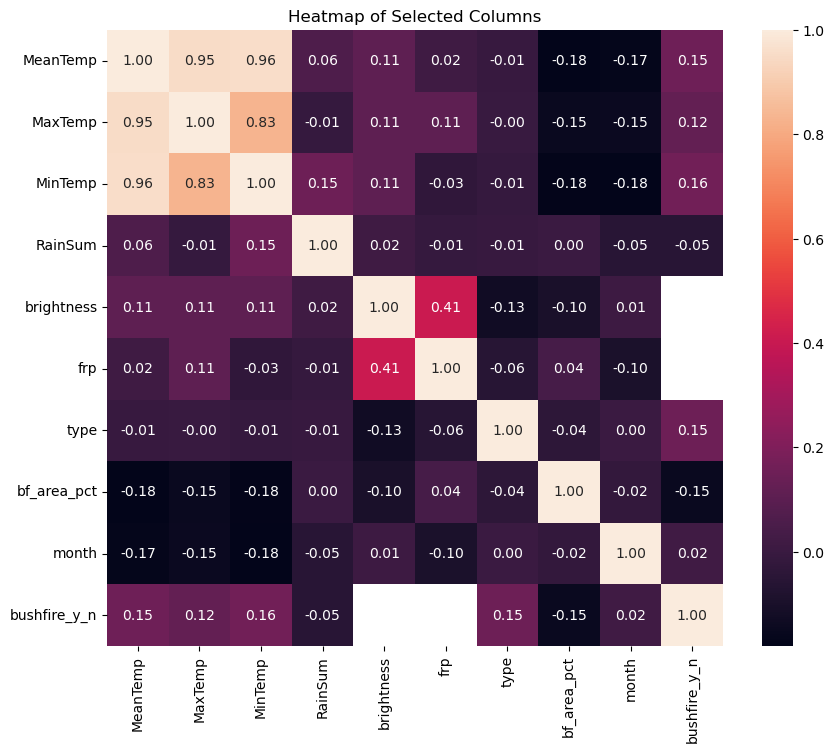

In [81]:
# Before I go any further I wan't to take a look at correlation between features
# Heatmap for selected columns (wouldn't run on all data - not enough memory)

# Create a subset of the DataFrame
columns_of_interest = ['MeanTemp', 'MaxTemp', 'MinTemp', 'RainSum', 'brightness','frp', 'type', 'bf_area_pct', 'month', 'bushfire_y_n']
subset_df = final_merged_df[columns_of_interest]

# Compute the correlation matrix (or any other matrix you want to visualize)
correlation_matrix = subset_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', square=True)
plt.title('Heatmap of Selected Columns')
plt.show()

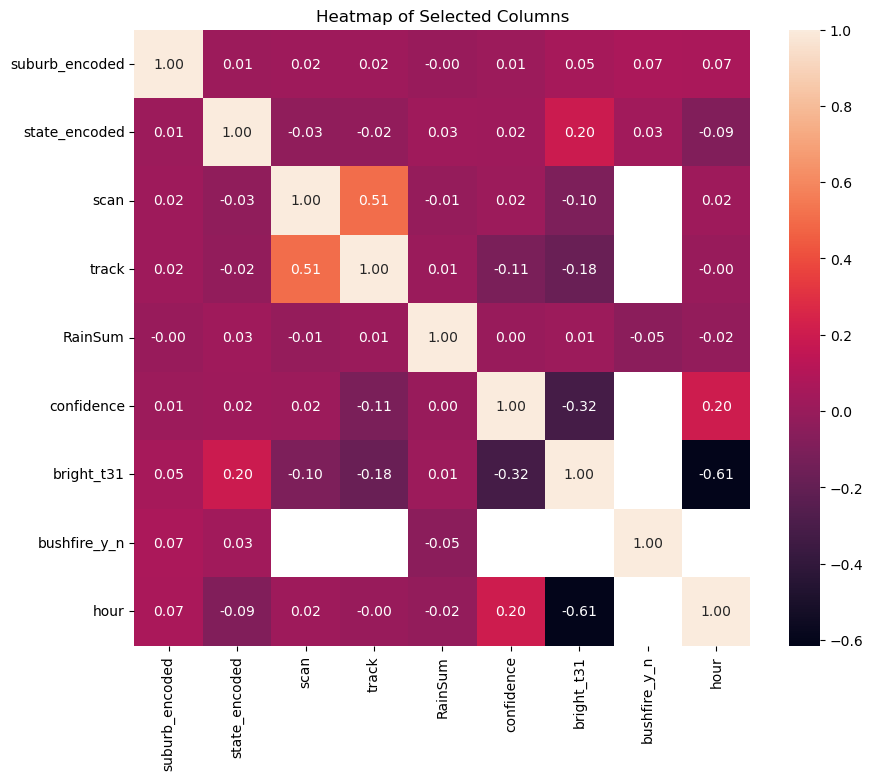

In [82]:
# Heatmap for selected columns (wouldn't run on all data - not enough memory)

# Create a subset of the DataFrame
columns_of_interest = ['suburb_encoded', 'state_encoded', 'scan', 'track', 'RainSum', 'confidence','bright_t31', 'bushfire_y_n', 'hour']
subset_df2 = final_merged_df[columns_of_interest]

# Compute the correlation matrix (or any other matrix you want to visualize)
correlation_matrix = subset_df2.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', square=True)
plt.title('Heatmap of Selected Columns')
plt.show()

In [83]:
# I still have NaNs for a few columns, but that should not prevent me from predicting if a bushfire will occur
# Theoretically the missing values should all be 0, but that would probably lead to it learning that no data = no bushfire
# I can then use the available data to predict how intense a fire will be

In [84]:
# Scale the numerical data (not the encoded)
from sklearn.preprocessing import StandardScaler

# Specify the columns to scale
columns_to_scale = ['MeanTemp', 'MaxTemp', 'MinTemp', 'RainSum', 'brightness', 'scan', 'track', 'bright_t31', 'frp', 'area', 'bf_area', 'bf_area_pct']

# Instantiate the scaler
scaler = StandardScaler()

# Fit and transform the selected columns
final_merged_df[columns_to_scale] = scaler.fit_transform(final_merged_df[columns_to_scale])

# Display the updated DataFrame
final_merged_df.head()

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,brightness,scan,track,confidence,...,type,area,bf_area,bf_area_pct,bushfire_y_n,hour,suburb_encoded,state_encoded,year,month
0,aarons pass,NSW,0.006998,1.104096,-0.805344,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
1,aarons pass,NSW,0.283614,1.288863,-0.367486,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
2,aarons pass,NSW,1.066110,2.035631,0.516193,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
3,aarons pass,NSW,1.180231,2.589932,0.086295,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
4,aarons pass,NSW,-0.421211,-0.035302,-0.375447,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1


## Predicting Bushfire Probability

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [87]:
# Let's try modelling to predict bushfire probability
X = final_merged_df[['suburb_encoded', 'MaxTemp', 'MinTemp', 'RainSum', 'bf_area_pct', 'month']]
y = final_merged_df['bushfire_y_n']

In [88]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [89]:
X_train.shape, y_train.shape

((8754437, 6), (8754437,))

In [90]:
X_test.shape, y_test.shape

((2188610, 6), (2188610,))

In [91]:
# Create model
logreg = LogisticRegression(max_iter=400)

In [92]:
# Fit model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=400)

In [93]:
# Get predicted probabilities for training and test data
train_probs = logreg.predict_proba(X_train)[:, 1] 
test_probs = logreg.predict_proba(X_test)[:, 1] 

# Set a threshold for classification
threshold = 0.5
y_train_pred = (train_probs >= threshold).astype(int)
y_test_pred = (test_probs >= threshold).astype(int) 

# Calculate accuracy for training and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 0.9553
Test Accuracy: 0.9553


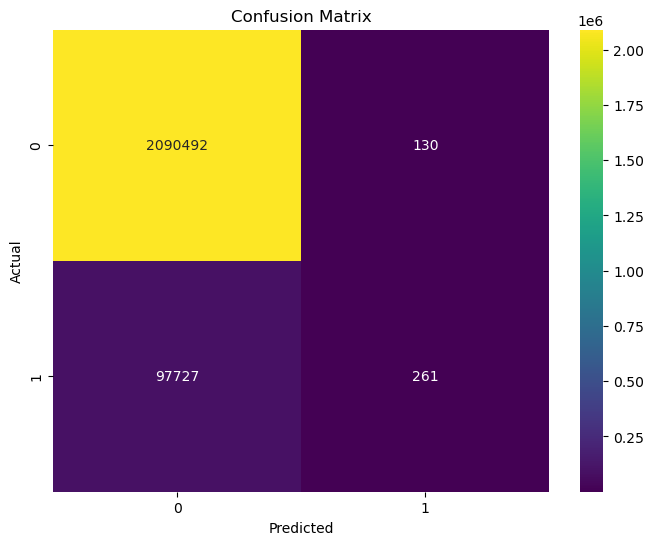

In [94]:
# Visualise the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [95]:
# Classification Report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98   2090622
           1       0.67      0.00      0.01     97988

    accuracy                           0.96   2188610
   macro avg       0.81      0.50      0.49   2188610
weighted avg       0.94      0.96      0.93   2188610



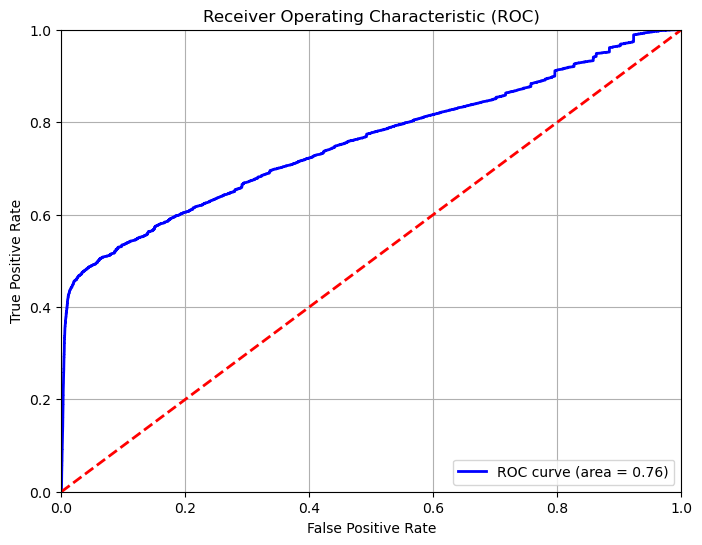

In [96]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test data
test_probs = logreg.predict_proba(X_test)[:, 1]  # Probability of the positive class (bushfire)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_probs)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [97]:
# At least it's not just guessing, which was a relief!

## Random Forest

In [99]:
# Random Forest may handle imbalance better This aggregation of trees can help mitigate the impact of class imbalance by capturing a variety of patterns across different subsets of the data.

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

In [101]:
# Note: I tried using Grid SearchCV but it was too computationally expensive!

In [102]:
X_1 = final_merged_df[['suburb_encoded', 'MaxTemp', 'MinTemp', 'RainSum', 'bf_area_pct', 'month']]
y_1 = final_merged_df['bushfire_y_n']

In [103]:
# Split the data
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size = 0.2, random_state = 42, stratify=y)

In [104]:
X_1_train.shape, y_1_train.shape

((8754437, 6), (8754437,))

In [105]:
X_1_test.shape, y_1_test.shape

((2188610, 6), (2188610,))

In [137]:
# Create a random forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter space (tweaked for speed)
param_distributions = {
    'n_estimators': [5, 10, 25],  # Reduced options
    'max_features': ['sqrt', 'log2'],  # Valid options
    'max_depth': [5, 10],  # Fewer options
    'min_samples_split': [5, 10],  # Fewer options
    'min_samples_leaf': [5, 10]  # Fewer options
}

# Best model tracking
best_model = None
best_score = 0
best_params = {}  # Initialize a dictionary to store best parameters

# Total combinations of parameters
total_combinations = (len(param_distributions['n_estimators']) *
                      len(param_distributions['max_features']) *
                      len(param_distributions['max_depth']) *
                      len(param_distributions['min_samples_split']) *
                      len(param_distributions['min_samples_leaf']))

# Use tqdm to show progress bar
with tqdm(total=total_combinations, desc="Training models") as pbar:
    # Loop through each combination of parameters
    for n in param_distributions['n_estimators']:
        for max_features in param_distributions['max_features']:
            for max_depth in param_distributions['max_depth']:
                for min_samples_split in param_distributions['min_samples_split']:
                    for min_samples_leaf in param_distributions['min_samples_leaf']:
                        rf.set_params(
                            n_estimators=n,
                            max_features=max_features,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf
                        )
                        rf.fit(X_1_train, y_1_train)

                        # Validate on test set
                        test_predictions = rf.predict(X_1_test)
                        test_score = accuracy_score(y_1_test, test_predictions)

                        # Update best model if current score is better
                        if test_score > best_score:
                            best_score = test_score
                            best_model = rf
                            best_params = {  # Update best parameters
                                'n_estimators': n,
                                'max_features': max_features,
                                'max_depth': max_depth,
                                'min_samples_split': min_samples_split,
                                'min_samples_leaf': min_samples_leaf
                            }

                        # Update progress bar
                        pbar.update(1)

# Display best score and parameters
print(f"Best test score: {best_score}")
print("Best parameters:", best_params)

Training models: 100%|██████████| 48/48 [1:58:59<00:00, 148.75s/it]

Best test score: 0.9901992588903459
Best parameters: {'n_estimators': 25, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 10}


In [149]:
# Create a Random Forest Classifier with the best parameters
rf_best = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Fit the model on the training data with a progress bar
for _ in tqdm(range(rf_best.n_estimators), desc="Fitting Random Forest"):
    rf_best.fit(X_1_train, y_1_train) 

Fitting Random Forest: 100%|██████████| 25/25 [1:35:44<00:00, 229.80s/it]


In [151]:
# Get predicted probabilities for the positive class (bushfire)
y_1_train_probs = rf.predict_proba(X_1_train)[:, 1]
y_1_test_probs = rf.predict_proba(X_1_test)[:, 1] 

# Classify predictions based on a threshold
y_1_train_pred = (y_1_train_probs >= 0.4).astype(int)
y_1_test_pred = (y_1_test_probs >= 0.4).astype(int)

# Calculate training and testing accuracy
training_accuracy = accuracy_score(y_1_train, y_1_train_pred)
testing_accuracy = accuracy_score(y_1_test, y_1_test_pred)

print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Testing Accuracy: {testing_accuracy:.4f}")

Training Accuracy: 0.9911
Testing Accuracy: 0.9910


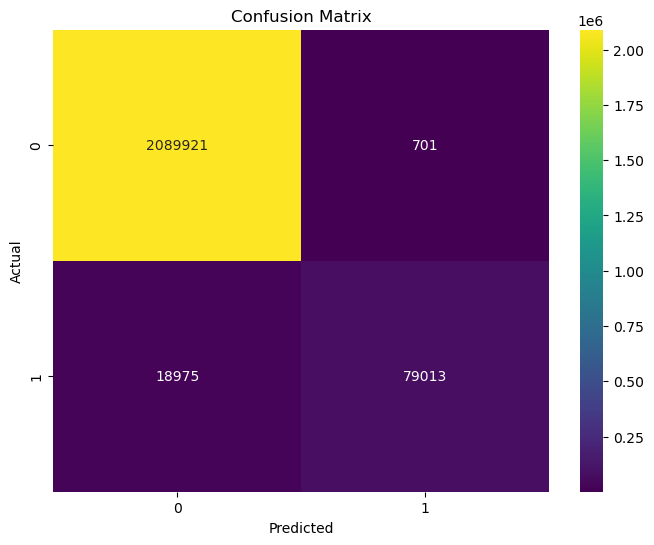

In [153]:
# Visualise the Confusion Matrix
conf_matrix = confusion_matrix(y_1_test, y_1_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [155]:
# Classification Report
print(classification_report(y_1_test, y_1_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00   2090622
           1       0.99      0.81      0.89     97988

    accuracy                           0.99   2188610
   macro avg       0.99      0.90      0.94   2188610
weighted avg       0.99      0.99      0.99   2188610



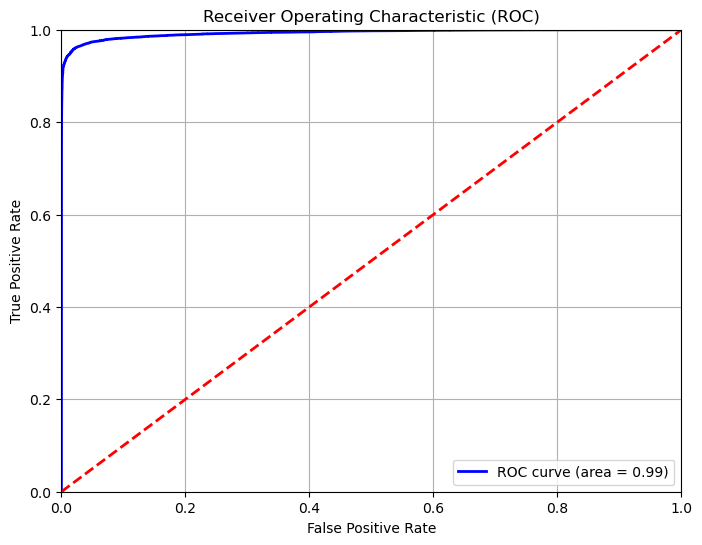

In [157]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Get predicted probabilities for the positive class
rf_probs = rf.predict_proba(X_1_test)[:, 1] 

# Compute ROC curve
fpr, tpr, _ = metrics.roc_curve(y_1_test, rf_probs)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# TOO good!!!
# Data too simple

## In the case of a bushfire happening, can we predict fire intensity?

In [159]:
# Create a copy of the final_merged df
intensity_df = final_merged_df.copy()
intensity_df.head()

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,brightness,scan,track,confidence,...,type,area,bf_area,bf_area_pct,bushfire_y_n,hour,suburb_encoded,state_encoded,year,month
0,aarons pass,NSW,0.006998,1.104096,-0.805344,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
1,aarons pass,NSW,0.283614,1.288863,-0.367486,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
2,aarons pass,NSW,1.066110,2.035631,0.516193,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
3,aarons pass,NSW,1.180231,2.589932,0.086295,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
4,aarons pass,NSW,-0.421211,-0.035302,-0.375447,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1


In [161]:
intensity_df.shape

(10943047, 23)

In [163]:
# Delete rows where bushfire = 0
intensity_df = intensity_df[intensity_df['bushfire_y_n'] != 0]
intensity_df.shape

(489938, 23)

In [165]:
intensity_df.sample(5)

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,brightness,scan,track,confidence,...,type,area,bf_area,bf_area_pct,bushfire_y_n,hour,suburb_encoded,state_encoded,year,month
7977700,port kembla,NSW,0.039974,-0.047235,-0.037499,-0.336557,-1.195358,-0.946315,-1.066244,1.0,...,2,-0.209307,-0.204014,-1.553939,1,14.0,5600,0,2022,11
6341607,moa island,QLD,1.491567,0.715931,1.969725,-0.336557,-1.625929,1.773463,0.482609,1.0,...,0,-0.104421,-0.144741,-0.924315,1,16.0,4523,1,2020,11
9557618,townsville city,QLD,1.276338,1.289864,1.663622,1.839661,1.765559,1.320166,0.310514,0.0,...,0,-0.217212,-0.204970,-1.551211,1,3.0,6802,1,2023,12
6352303,moa island,QLD,1.279676,0.492670,1.834387,-0.142862,0.811656,-0.719667,-0.980197,1.0,...,0,-0.104421,-0.144741,-0.924315,1,4.0,4523,1,2021,7
10570410,wonboyn,NSW,-0.448192,-0.616934,-0.156915,-0.325163,-1.617992,-1.626259,0.568657,1.0,...,0,-0.203770,-0.179210,0.971325,1,14.0,7491,0,2020,2


In [167]:
intensity_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489938 entries, 92669 to 10593088
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   suburb          489938 non-null  object 
 1   state           489938 non-null  object 
 2   MeanTemp        489938 non-null  float64
 3   MaxTemp         489938 non-null  float64
 4   MinTemp         489938 non-null  float64
 5   RainSum         489938 non-null  float64
 6   brightness      489938 non-null  float64
 7   scan            489938 non-null  float64
 8   track           489938 non-null  float64
 9   confidence      489938 non-null  float64
 10  bright_t31      489938 non-null  float64
 11  frp             489938 non-null  float64
 12  daynight        489938 non-null  float64
 13  type            489938 non-null  int32  
 14  area            489938 non-null  float64
 15  bf_area         489938 non-null  float64
 16  bf_area_pct     489938 non-null  float64
 17  bushfire_

In [169]:
intensity_df.isnull().sum()

suburb            0
state             0
MeanTemp          0
MaxTemp           0
MinTemp           0
RainSum           0
brightness        0
scan              0
track             0
confidence        0
bright_t31        0
frp               0
daynight          0
type              0
area              0
bf_area           0
bf_area_pct       0
bushfire_y_n      0
hour              0
suburb_encoded    0
state_encoded     0
year              0
month             0
dtype: int64

In [171]:
# I have my clean dataset back :-)

In [173]:
intensity_df.describe()

,MeanTemp,MaxTemp,MinTemp,RainSum,brightness,scan,track,confidence,bright_t31,frp,...,type,area,bf_area,bf_area_pct,bushfire_y_n,hour,suburb_encoded,state_encoded,year,month
count,489938.000000,489938.000000,489938.000000,489938.000000,4.899380e+05,4.899380e+05,4.899380e+05,489938.000000,4.899380e+05,4.899380e+05,...,489938.000000,489938.000000,489938.000000,489938.000000,489938.0,489938.000000,489938.000000,489938.000000,489938.000000,489938.000000
mean,0.712572,0.557701,0.746359,-0.242140,3.092209e-15,-1.030272e-16,-1.809010e-15,0.925956,4.476580e-15,-1.763529e-16,...,0.048816,-0.116645,-0.132965,-0.689867,1.0,8.339549,4601.923621,0.502839,2021.510165,6.509160
std,0.996268,0.865754,1.217270,0.325078,1.000001e+00,1.000001e+00,1.000001e+00,0.261843,1.000001e+00,1.000001e+00,...,0.314707,0.145149,0.119657,0.852575,0.0,5.596927,1804.327007,0.499992,1.342579,3.854564
min,-2.946578,-3.359418,-3.112780,-0.336557,-1.805995e+00,-1.626259e+00,-1.066244e+00,0.000000,-1.367765e+01,-4.945219e-01,...,0.000000,-0.218433,-0.205115,-1.736388,1.0,2.000000,69.000000,0.000000,2020.000000,1.000000
25%,0.056680,0.266176,-0.302762,-0.336557,-9.810653e-01,-7.196667e-01,-8.941494e-01,1.000000,-6.087832e-01,-3.978003e-01,...,0.000000,-0.210354,-0.202658,-1.551211,1.0,3.000000,3448.000000,0.000000,2020.000000,3.000000
50%,1.135236,0.550795,1.146391,-0.336557,1.732410e-01,-2.663705e-01,-2.918176e-01,1.000000,-1.053760e-01,-2.547757e-01,...,0.000000,-0.104709,-0.150665,-0.924315,1.0,4.000000,4523.000000,1.000000,2021.000000,7.000000
75%,1.382896,1.016177,1.786620,-0.279588,7.372488e-01,6.402220e-01,7.407514e-01,1.000000,5.962008e-01,-2.682102e-03,...,0.000000,-0.104421,-0.144741,-0.285934,1.0,15.000000,6802.000000,1.000000,2023.000000,10.000000
max,3.422386,3.475044,3.115084,16.833919,1.765559e+00,3.813296e+00,2.547747e+00,1.000000,7.787598e+00,5.102107e+01,...,3.000000,0.439486,0.373534,1.184135,1.0,17.000000,7502.000000,1.000000,2024.000000,12.000000


In [175]:
# I can delete the bushfire y/n column
intensity_df = intensity_df.drop(columns=['bushfire_y_n'])
intensity_df.head()

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,brightness,scan,track,confidence,...,daynight,type,area,bf_area,bf_area_pct,hour,suburb_encoded,state_encoded,year,month
92669,allambie heights,NSW,0.006603,0.204588,-0.055730,-0.336557,0.530396,-1.172963,0.740751,1.0,...,0.0,0,-0.214066,-0.198592,0.526965,4.0,69,0,2021,8
92701,allambie heights,NSW,-0.045859,0.243081,-0.294562,-0.336557,1.765559,-1.172963,0.740751,0.0,...,0.0,3,-0.214066,-0.198592,0.526965,4.0,69,0,2021,9
92702,allambie heights,NSW,-0.045859,0.243081,-0.294562,-0.336557,-0.238480,-1.172963,0.740751,1.0,...,0.0,3,-0.214066,-0.198592,0.526965,4.0,69,0,2021,9
92703,allambie heights,NSW,-0.045859,0.243081,-0.294562,-0.336557,0.619685,-1.172963,0.740751,1.0,...,0.0,3,-0.214066,-0.198592,0.526965,4.0,69,0,2021,9
93139,allambie heights,NSW,0.053955,-0.211139,0.119413,-0.336557,0.698061,0.526898,0.052372,1.0,...,0.0,0,-0.214066,-0.198592,0.526965,3.0,69,0,2022,12


## Modelling

In [178]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

In [180]:
# Linear Regression

In [182]:
# Define features and target
X_3 = intensity_df.drop(columns=['frp', 'suburb', 'state'])  # features
y_3 = intensity_df['frp']  # target variable

In [184]:
# Split the data
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.2, random_state=42)

In [186]:
# Create a linear regression model
lr_model = LinearRegression()

In [188]:
# Fit the model to the training data
lr_model.fit(X_3_train, y_3_train)

LinearRegression()

In [190]:
# Make predictions on the training set
y_3_train_pred = lr_model.predict(X_3_train)

# Make predictions on the test set
y_3_test_pred = lr_model.predict(X_3_test)

# Evaluate the model on training data
train_mse = mean_squared_error(y_3_train, y_3_train_pred)
train_r2 = r2_score(y_3_train, y_3_train_pred)

# Evaluate the model on test data
test_mse = mean_squared_error(y_3_test, y_3_test_pred)
test_r2 = r2_score(y_3_test, y_3_test_pred)

# Output the results
print("Training Data Evaluation:")
print(f'Mean Squared Error: {train_mse:.2f}')
print(f'R^2 Score: {train_r2:.2f}')

print("\nTest Data Evaluation:")
print(f'Mean Squared Error: {test_mse:.2f}')
print(f'R^2 Score: {test_r2:.2f}')

Training Data Evaluation:
Mean Squared Error: 0.70
R^2 Score: 0.28

Test Data Evaluation:
Mean Squared Error: 0.81
R^2 Score: 0.26


## Random Forest

In [194]:
# Define features and target
X_4 = intensity_df.drop(columns=['frp', 'suburb', 'state'])  # features
y_4 = intensity_df['frp']  # target variable

In [196]:
# Split the data
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, test_size=0.2, random_state=42)

In [198]:
from sklearn.model_selection import GridSearchCV

In [200]:
# Create the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

In [206]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
from tqdm import tqdm

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=0)

best_score = -np.inf
best_params = None

# Create a list of all parameter combinations
from itertools import product
param_combinations = list(product(param_grid['n_estimators'], param_grid['max_depth'], param_grid['min_samples_split']))

# Iterate over each combination of hyperparameters with a progress bar
for n_estimators, max_depth, min_samples_split in tqdm(param_combinations, desc='Hyperparameter combinations'):
    # Set the current parameters
    rf_model.set_params(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    
    # Fit the model on the training data
    rf_model.fit(X_4_train, y_4_train)
    
    # Make predictions on the training data
    y_4_train_pred = rf_model.predict(X_4_train)
    
    # Calculate mean absolute error as the score
    score = -mean_absolute_error(y_4_train, y_4_train_pred)
    
    # Check if the current score is better than the best score
    if score > best_score:
        best_score = score
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split
        }

# Output the best parameters and score
print(f'Best Score: {-best_score} with params: {best_params}')

Hyperparameter combinations: 100%|██████████| 18/18 [2:02:44<00:00, 409.12s/it]

Best Score: 0.10270311658121314 with params: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}


In [ ]:
# Output of above in case I have to re-run this code
# Best Score: 0.10270311658121314 with params: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}

In [210]:
from sklearn.model_selection import KFold
import itertools
from tqdm import tqdm

# Parameter grid:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Create a GridSearchCV-like process manually
kf = KFold(n_splits=5)
best_score = -np.inf
best_params = None

# Generate all combinations of parameters
param_combinations = list(itertools.product(*param_grid.values()))

# Convert X_4_train to a NumPy array if it's a DataFrame
X_array = X_4_train.to_numpy() if isinstance(X_4_train, pd.DataFrame) else X_4_train

# Convert y_4_train to a NumPy array
y_array = y_4_train.to_numpy() if isinstance(y_4_train, pd.Series) else y_4_train

# Initialize the model for regression
rf_model = RandomForestRegressor(random_state=42)

# Iterate over each combination of hyperparameters
for params in tqdm(param_combinations, desc='Hyperparameter combinations'):
    param_dict = {key: value for key, value in zip(param_grid.keys(), params)}
    
    rf_model.set_params(**param_dict)  # Set model parameters
    scores = []
    
    # Cross-validation
    for train_index, val_index in kf.split(X_array):
        X_train_fold, X_val_fold = X_array[train_index], X_array[val_index]
        y_train_fold, y_val_fold = y_array[train_index], y_array[val_index]

        rf_model.fit(X_train_fold, y_train_fold)
        score = rf_model.score(X_val_fold, y_val_fold)
        scores.append(score)
    
    mean_score = np.mean(scores)
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = param_dict

print(f'Best Score: {best_score} with params: {best_params}')

Hyperparameter combinations: 100%|██████████| 8/8 [2:58:46<00:00, 1340.78s/it]

Best Score: 0.4431740765940836 with params: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5}


In [212]:
# Use the best parameters to train the model
best_params = {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5}
rf_model = RandomForestRegressor(**best_params, random_state=0)
rf_model.fit(X_4_train, y_4_train)

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=200,
                      random_state=0)

In [214]:
# Make predictions on the training set
y_4_train_pred = rf_model.predict(X_4_train)

# Make predictions on the test set
y_4_test_pred = rf_model.predict(X_4_test)

# Evaluate the model on training data
train_mse = mean_squared_error(y_4_train, y_4_train_pred)
train_r2 = r2_score(y_4_train, y_4_train_pred)

# Evaluate the model on test data
test_mse = mean_squared_error(y_4_test, y_4_test_pred)
test_r2 = r2_score(y_4_test, y_4_test_pred)

# Output the results
print("Training Data Evaluation:")
print(f'Mean Squared Error: {train_mse:.2f}')
print(f'R^2 Score: {train_r2:.2f}')

print("\nTest Data Evaluation:")
print(f'Mean Squared Error: {test_mse:.2f}')
print(f'R^2 Score: {test_r2:.2f}')

Training Data Evaluation:
Mean Squared Error: 0.22
R^2 Score: 0.78

Test Data Evaluation:
Mean Squared Error: 0.64
R^2 Score: 0.42


## Predict Fires for a set of conditions

In [216]:
# Where will a fire occur?

In [218]:
final_merged_df.head()

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,brightness,scan,track,confidence,...,type,area,bf_area,bf_area_pct,bushfire_y_n,hour,suburb_encoded,state_encoded,year,month
0,aarons pass,NSW,0.006998,1.104096,-0.805344,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
1,aarons pass,NSW,0.283614,1.288863,-0.367486,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
2,aarons pass,NSW,1.066110,2.035631,0.516193,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
3,aarons pass,NSW,1.180231,2.589932,0.086295,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1
4,aarons pass,NSW,-0.421211,-0.035302,-0.375447,-0.336557,NaN,NaN,NaN,NaN,...,0,-0.163481,-0.100797,1.184078,0,NaN,0,0,2020,1


In [220]:
final_merged_df.describe()

,MeanTemp,MaxTemp,MinTemp,RainSum,brightness,scan,track,confidence,bright_t31,frp,...,type,area,bf_area,bf_area_pct,bushfire_y_n,hour,suburb_encoded,state_encoded,year,month
count,1.094305e+07,1.094305e+07,1.094305e+07,1.094305e+07,4.899380e+05,4.899380e+05,4.899380e+05,489938.000000,4.899380e+05,4.899380e+05,...,1.094305e+07,1.094305e+07,1.094305e+07,1.094305e+07,1.094305e+07,489938.000000,1.094305e+07,1.094305e+07,1.094305e+07,1.094305e+07
mean,-1.662233e-19,1.072431e-15,2.632686e-15,-1.317527e-16,3.089831e-15,-1.149049e-16,-1.818756e-15,0.925956,4.472171e-15,-1.574994e-16,...,2.185589e-03,4.041720e-16,-1.243974e-16,4.405021e-15,4.477163e-02,8.339549,3.894867e+03,4.273742e-01,2.021804e+03,6.216784e+00
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.261843,1.000001e+00,1.000001e+00,...,6.735056e-02,1.000000e+00,1.000000e+00,1.000000e+00,2.068022e-01,5.596927,2.227181e+03,4.946974e-01,1.338289e+00,3.427460e+00
min,-4.178704e+00,-4.155688e+00,-4.295875e+00,-3.365567e-01,-1.805995e+00,-1.626259e+00,-1.066244e+00,0.000000,-1.367765e+01,-4.945219e-01,...,0.000000e+00,-2.184422e-01,-2.051297e-01,-1.740939e+00,0.000000e+00,2.000000,0.000000e+00,0.000000e+00,2.020000e+03,1.000000e+00
25%,-7.241400e-01,-6.834501e-01,-7.554286e-01,-3.365567e-01,-9.810653e-01,-7.196667e-01,-8.941494e-01,1.000000,-6.087832e-01,-3.978003e-01,...,0.000000e+00,-2.117661e-01,-2.000710e-01,-9.243146e-01,0.000000e+00,3.000000,1.996000e+03,0.000000e+00,2.021000e+03,3.000000e+00
50%,5.808335e-02,4.114551e-02,3.526474e-02,-3.251629e-01,1.732410e-01,-2.663705e-01,-2.918176e-01,1.000000,-1.053760e-01,-2.547757e-01,...,0.000000e+00,-1.917276e-01,-1.792161e-01,1.349553e-01,0.000000e+00,4.000000,3.911000e+03,0.000000e+00,2.022000e+03,6.000000e+00
75%,7.630859e-01,7.157767e-01,7.699123e-01,-1.200743e-01,7.372488e-01,6.402220e-01,7.407514e-01,1.000000,5.962008e-01,-2.682102e-03,...,0.000000e+00,-1.178663e-01,-1.081754e-01,1.013900e+00,0.000000e+00,15.000000,5.779000e+03,1.000000e+00,2.023000e+03,9.000000e+00
max,3.943746e+00,3.894466e+00,3.552942e+00,6.083682e+01,1.765559e+00,3.813296e+00,2.547747e+00,1.000000,7.787598e+00,5.102107e+01,...,3.000000e+00,2.410277e+01,2.483688e+01,1.184135e+00,1.000000e+00,17.000000,7.762000e+03,1.000000e+00,2.024000e+03,1.200000e+01


In [221]:
# Let's make that easier to read by changing the format of scientific notation.
# Generate the description
desc = final_merged_df.describe()

# Apply formatting to the description using map
desc_formatted = desc.apply(lambda x: x.map(lambda y: f'{y:.2f}'))

# Display the formatted description in DataFrame format
formatted_df = pd.DataFrame(desc_formatted)
formatted_df.index.name = 'Statistic'  # Set index name for clarity
print(formatted_df)

              MeanTemp      MaxTemp      MinTemp      RainSum brightness  \
Statistic                                                                  
count      10943047.00  10943047.00  10943047.00  10943047.00  489938.00   
mean             -0.00         0.00         0.00        -0.00       0.00   
std               1.00         1.00         1.00         1.00       1.00   
min              -4.18        -4.16        -4.30        -0.34      -1.81   
25%              -0.72        -0.68        -0.76        -0.34      -0.98   
50%               0.06         0.04         0.04        -0.33       0.17   
75%               0.76         0.72         0.77        -0.12       0.74   
max               3.94         3.89         3.55        60.84       1.77   

                scan      track confidence bright_t31        frp  ...  \
Statistic                                                         ...   
count      489938.00  489938.00  489938.00  489938.00  489938.00  ...   
mean           -0.00

In [234]:
# Extract unique encoded suburbs and their corresponding states
unique_suburbs = final_merged_df[['suburb_encoded', 'state_encoded']].drop_duplicates()

# Create a DataFrame for all unique encoded suburbs with fixed conditions
new_data = pd.DataFrame({
    'suburb_encoded': unique_suburbs['suburb_encoded'],
    'MaxTemp': 3.89, # Approx 30 degrees
    'MinTemp': 3.55, # Approx 12 degrees
    'RainSum': -0.34, # Approx 2 mm
    'bf_area_pct': 1.18, # Approx 1% 
    'month': 2
})

In [236]:
new_data.head()

,suburb_encoded,MaxTemp,MinTemp,RainSum,bf_area_pct,month
0,0,3.89,3.55,-0.34,1.18,2
1674,1,3.89,3.55,-0.34,1.18,2
3348,2,3.89,3.55,-0.34,1.18,2
5022,5,3.89,3.55,-0.34,1.18,2
6696,7,3.89,3.55,-0.34,1.18,2


In [239]:
# Make predictions
predicted_probs = logreg.predict_proba(new_data)[:, 1]  # Get probabilities for class 1 (bushfire)

# Create a DataFrame with suburbs and their predicted probabilities
results_df = pd.DataFrame({
    'suburb_encoded': new_data['suburb_encoded'],
    'month': new_data['month'],
    'Bushfire_Probability': predicted_probs
})

results_df.head()

,suburb_encoded,month,Bushfire_Probability
0,0,2,0.101127
1674,1,2,0.101140
3348,2,2,0.101153
5022,5,2,0.101192
6696,7,2,0.101218


In [241]:
# Get the unique number of suburb_encoded values
unique_suburb_count = results_df['suburb_encoded'].nunique()

# Display the result
print(f"Unique number of suburb_encoded values: {unique_suburb_count}")

Unique number of suburb_encoded values: 6238


In [245]:
# Filter suburbs with a probability above a certain threshold
threshold = 0.2  # Artifically low to ensure I capture examples from both States
likely_bushfires = results_df[results_df['Bushfire_Probability'] > threshold]

# Display the suburbs likely to have bushfires
likely_bushfires.sample(10)

,suburb_encoded,month,Bushfire_Probability
9436432,6773,2,0.228934
10082766,7134,2,0.238192
9606885,6829,2,0.230354
8993757,6466,2,0.221262
9059043,6510,2,0.222350
10630009,7548,2,0.249122
8487471,6025,2,0.210567
8771683,6249,2,0.215951
8557569,6078,2,0.211832
8938515,6429,2,0.220350


In [247]:
likely_bushfires.shape

(1702, 3)

In [253]:
# Create a reverse mapping dictionary
reverse_suburb_encoding_dict = {v: k for k, v in suburb_encoding_dict.items()}

# Decode the suburbs using the reverse mapping
likely_bushfires.loc[:, 'decoded_suburb'] = likely_bushfires['suburb_encoded'].map(reverse_suburb_encoding_dict)
likely_bushfires.sample(15)

,suburb_encoded,month,Bushfire_Probability,decoded_suburb
8086420,5681,2,0.202491,quinalow
9868582,6991,2,0.234494,urunga
9128416,6554,2,0.223442,temagog
9237226,6638,2,0.225538,the pilliga
9631995,6844,2,0.230735,tullera
10278905,7283,2,0.242088,west gladstone
8305005,5874,2,0.206993,roseberg
10327451,7322,2,0.243114,wetheron
8465709,6009,2,0.210186,sanger
8796793,6291,2,0.216972,st lucia


In [256]:
## How intense might the fire be?

In [264]:
# Get the mean frp for each suburb:state:month combination

# Create a key for merging based on suburb, state, and month in likely_bushfires
likely_bushfires.loc[:, 'key'] = likely_bushfires['suburb_encoded'].astype(str) + '_' + \
                                                                    likely_bushfires['month'].astype(str)

# Create a key for intensity_df
intensity_df.loc[:, 'key'] = intensity_df['suburb_encoded'].astype(str) + '_' + \
                                                            intensity_df['month'].astype(str)

In [266]:
likely_bushfires.sample(5)

,suburb_encoded,month,Bushfire_Probability,decoded_suburb,key
8965299,6449,2,0.220843,takura,6449_2
9429736,6769,2,0.228833,tooranie,6769_2
8718115,6200,2,0.214765,south stradbroke,6200_2
10660141,7571,2,0.249739,woondum,7571_2
8970321,6452,2,0.220917,talawanta,6452_2


In [268]:
likely_bushfires.shape

(1702, 5)

In [270]:
intensity_df.head()

,suburb,state,MeanTemp,MaxTemp,MinTemp,RainSum,brightness,scan,track,confidence,...,type,area,bf_area,bf_area_pct,hour,suburb_encoded,state_encoded,year,month,key
92669,allambie heights,NSW,0.006603,0.204588,-0.055730,-0.336557,0.530396,-1.172963,0.740751,1.0,...,0,-0.214066,-0.198592,0.526965,4.0,69,0,2021,8,69_8
92701,allambie heights,NSW,-0.045859,0.243081,-0.294562,-0.336557,1.765559,-1.172963,0.740751,0.0,...,3,-0.214066,-0.198592,0.526965,4.0,69,0,2021,9,69_9
92702,allambie heights,NSW,-0.045859,0.243081,-0.294562,-0.336557,-0.238480,-1.172963,0.740751,1.0,...,3,-0.214066,-0.198592,0.526965,4.0,69,0,2021,9,69_9
92703,allambie heights,NSW,-0.045859,0.243081,-0.294562,-0.336557,0.619685,-1.172963,0.740751,1.0,...,3,-0.214066,-0.198592,0.526965,4.0,69,0,2021,9,69_9
93139,allambie heights,NSW,0.053955,-0.211139,0.119413,-0.336557,0.698061,0.526898,0.052372,1.0,...,0,-0.214066,-0.198592,0.526965,3.0,69,0,2022,12,69_12


In [272]:
# Calculate mean intensity for each key and add as a new column
intensity_df['mean_intensity'] = intensity_df.groupby('key')['frp'].transform('mean')

intensity_df.head().T

,92669,92701,92702,92703,93139
suburb,allambie heights,allambie heights,allambie heights,allambie heights,allambie heights
state,NSW,NSW,NSW,NSW,NSW
MeanTemp,0.006603,-0.045859,-0.045859,-0.045859,0.053955
MaxTemp,0.204588,0.243081,0.243081,0.243081,-0.211139
MinTemp,-0.05573,-0.294562,-0.294562,-0.294562,0.119413
RainSum,-0.336557,-0.336557,-0.336557,-0.336557,-0.336557
brightness,0.530396,1.765559,-0.23848,0.619685,0.698061
scan,-1.172963,-1.172963,-1.172963,-1.172963,0.526898
track,0.740751,0.740751,0.740751,0.740751,0.052372
confidence,1.0,0.0,1.0,1.0,1.0


In [274]:
intensity_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489938 entries, 92669 to 10593088
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   suburb          489938 non-null  object 
 1   state           489938 non-null  object 
 2   MeanTemp        489938 non-null  float64
 3   MaxTemp         489938 non-null  float64
 4   MinTemp         489938 non-null  float64
 5   RainSum         489938 non-null  float64
 6   brightness      489938 non-null  float64
 7   scan            489938 non-null  float64
 8   track           489938 non-null  float64
 9   confidence      489938 non-null  float64
 10  bright_t31      489938 non-null  float64
 11  frp             489938 non-null  float64
 12  daynight        489938 non-null  float64
 13  type            489938 non-null  int32  
 14  area            489938 non-null  float64
 15  bf_area         489938 non-null  float64
 16  bf_area_pct     489938 non-null  float64
 17  hour     

In [276]:
# Before merging, create a copy of the original DataFrame
original_likely_bushfires = likely_bushfires.copy()

In [278]:
merged_likely_bushfires = likely_bushfires.merge(intensity_df[['key', 'mean_intensity']], on='key', how='left')

In [280]:
merged_likely_bushfires.sample(10)

,suburb_encoded,month,Bushfire_Probability,decoded_suburb,key,mean_intensity
3835,6802,2,0.229668,townsville city,6802_2,-0.096149
1987,6728,2,0.227798,tocumwal,6728_2,NaN
929,5746,2,0.203999,redbournberry,5746_2,-0.293217
1283,6034,2,0.210781,scone,6034_2,-0.254016
2661,6802,2,0.229668,townsville city,6802_2,-0.096149
10350,7491,2,0.247598,wonboyn,7491_2,0.117366
8456,7491,2,0.247598,wonboyn,7491_2,0.117366
8417,7491,2,0.247598,wonboyn,7491_2,0.117366
9204,7491,2,0.247598,wonboyn,7491_2,0.117366
9409,7491,2,0.247598,wonboyn,7491_2,0.117366


In [282]:
merged_likely_bushfires.shape

(11252, 6)

In [284]:
# Check unique keys in likely_bushfires (no of bushfires predicted)
print(likely_bushfires['key'].nunique())

# Check unique keys in intensity_df (mean intensity)
print(intensity_df['key'].nunique())

1700
702


In [286]:
key_to_find = "0_0_2"
matching_rows = intensity_df[intensity_df['key'] == key_to_find]
print(matching_rows)

Empty DataFrame
Columns: [suburb, state, MeanTemp, MaxTemp, MinTemp, RainSum, brightness, scan, track, confidence, bright_t31, frp, daynight, type, area, bf_area, bf_area_pct, hour, suburb_encoded, state_encoded, year, month, key, mean_intensity]
Index: []

[0 rows x 24 columns]


In [288]:
key_to_find = "69_0_8"
matching_rows = intensity_df[intensity_df['key'] == key_to_find]
print(matching_rows)

Empty DataFrame
Columns: [suburb, state, MeanTemp, MaxTemp, MinTemp, RainSum, brightness, scan, track, confidence, bright_t31, frp, daynight, type, area, bf_area, bf_area_pct, hour, suburb_encoded, state_encoded, year, month, key, mean_intensity]
Index: []

[0 rows x 24 columns]


In [290]:
key_to_find = "69_0_9"
matching_rows = intensity_df[intensity_df['key'] == key_to_find]
print(matching_rows)

Empty DataFrame
Columns: [suburb, state, MeanTemp, MaxTemp, MinTemp, RainSum, brightness, scan, track, confidence, bright_t31, frp, daynight, type, area, bf_area, bf_area_pct, hour, suburb_encoded, state_encoded, year, month, key, mean_intensity]
Index: []

[0 rows x 24 columns]


In [292]:
# Empty rows are where there is no historical fire data for that combination of suburb/state/month

In [294]:
merged_likely_bushfires.shape

(11252, 6)

In [296]:
# More rows as each key in intensity_df can be seen more than once
# Count the number of duplicate rows
num_duplicates = merged_likely_bushfires.duplicated().sum()

print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 9552


In [298]:
duplicates_df = merged_likely_bushfires[merged_likely_bushfires.duplicated()]
duplicates_df.head(10)

,suburb_encoded,month,Bushfire_Probability,decoded_suburb,key,mean_intensity
22,5600,2,0.200623,port kembla,5600_2,-0.361287
23,5600,2,0.200623,port kembla,5600_2,-0.361287
24,5600,2,0.200623,port kembla,5600_2,-0.361287
25,5600,2,0.200623,port kembla,5600_2,-0.361287
26,5600,2,0.200623,port kembla,5600_2,-0.361287
27,5600,2,0.200623,port kembla,5600_2,-0.361287
28,5600,2,0.200623,port kembla,5600_2,-0.361287
29,5600,2,0.200623,port kembla,5600_2,-0.361287
30,5600,2,0.200623,port kembla,5600_2,-0.361287
31,5600,2,0.200623,port kembla,5600_2,-0.361287


In [300]:
# These are the duplicate rows and can be dropped to get me back to 4153 likely bushfires
merged_likely_bushfires = merged_likely_bushfires.drop_duplicates()

# Reset the index if needed
merged_likely_bushfires.reset_index(drop=True, inplace=True)

merged_likely_bushfires.head()

,suburb_encoded,month,Bushfire_Probability,decoded_suburb,key,mean_intensity
0,5573,2,0.200003,pleystowe,5573_2,NaN
1,5575,2,0.200049,point arkwright,5575_2,NaN
2,5576,2,0.200072,point clare,5576_2,NaN
3,5577,2,0.200095,point frederick,5577_2,NaN
4,5578,2,0.200118,point lookout,5578_2,NaN


In [302]:
merged_likely_bushfires.shape

(1700, 6)

In [304]:
# Yay, back to 4153 rows.
merged_likely_bushfires.isnull().sum()

suburb_encoded             0
month                      0
Bushfire_Probability       0
decoded_suburb             0
key                        0
mean_intensity          1677
dtype: int64

In [306]:
merged_likely_bushfires.sample(5)

,suburb_encoded,month,Bushfire_Probability,decoded_suburb,key,mean_intensity
192,5842,2,0.206241,rockton,5842_2,NaN
1203,7140,2,0.238348,wards mistake,7140_2,NaN
1343,7322,2,0.243114,wetheron,7322_2,NaN
904,6809,2,0.229846,trebonne,6809_2,NaN
520,6324,2,0.217776,stockhaven,6324_2,NaN


In [308]:
# If I don't have data relating to intensity (because there was no historical data for that suburb/month) I can't use it
# Filter for those rows that have intensity data

# Find rows where mean_intensity is not NaN
merged_likely_bushfires = merged_likely_bushfires[merged_likely_bushfires['mean_intensity'].notna()]

# Display the updated DataFrame
merged_likely_bushfires.head()


,suburb_encoded,month,Bushfire_Probability,decoded_suburb,key,mean_intensity
21,5600,2,0.200623,port kembla,5600_2,-0.361287
52,5643,2,0.201613,pulganbar,5643_2,-0.143450
126,5746,2,0.203999,redbournberry,5746_2,-0.293217
179,5825,2,0.205843,robin hill,5825_2,-0.426868
206,5868,2,0.206852,ropes crossing,5868_2,-0.407776


In [310]:
merged_likely_bushfires.isnull().sum()

suburb_encoded          0
month                   0
Bushfire_Probability    0
decoded_suburb          0
key                     0
mean_intensity          0
dtype: int64

In [312]:
# So I now know where the fires are likely to be and how intense (where that data is available)
# Let's plot them

In [320]:
import time
from geopy.geocoders import Nominatim
from tqdm import tqdm
import pandas as pd

# Initialize the geolocator with a user-agent
geolocator = Nominatim(user_agent="YourAppName")

# Geocode locations to get lat/long
def geocode_location(row):
    location = f"{row['decoded_suburb']}, Australia"
    
    try:
        loc = geolocator.geocode(location)
        return (loc.latitude, loc.longitude) if loc else (None, None)
    except Exception as e:
        print(f"Error geocoding {location}: {e}")
        return None, None

# Enable progress bar
tqdm.pandas(desc="Geocoding Progress")

# Apply geocoding with a progress bar
merged_likely_bushfires['coordinates'] = merged_likely_bushfires.progress_apply(geocode_location, axis=1)

# Delay between requests (if you're making multiple requests)
time.sleep(1)  # Adjust as needed

# Extract latitude and longitude
merged_likely_bushfires[['latitude', 'longitude']] = pd.DataFrame(merged_likely_bushfires['coordinates'].tolist(), index=merged_likely_bushfires.index)

Geocoding Progress: 100%|██████████| 23/23 [00:12<00:00,  1.88it/s]


In [322]:
merged_likely_bushfires.to_pickle('merged_likely_bushfires_with_coordinates.pkl')

In [324]:
merged_likely_bushfires.sample(5)

,suburb_encoded,month,Bushfire_Probability,decoded_suburb,key,mean_intensity,coordinates,latitude,longitude
179,5825,2,0.205843,robin hill,5825_2,-0.426868,"(-33.4316667, 149.5344444)",-33.431667,149.534444
678,6539,2,0.223070,taylors arm,6539_2,-0.417636,"(-30.7671986, 152.7288375)",-30.767199,152.728837
397,6132,2,0.213127,skennars head,6132_2,-0.376535,"(-28.8277755, 153.6026015)",-28.827776,153.602601
1141,7069,2,0.236506,wallaga lake,7069_2,0.061299,"(-36.3705, 150.0671)",-36.370500,150.067100
658,6516,2,0.222499,taree,6516_2,-0.289034,"(-31.912864, 152.4608481)",-31.912864,152.460848


In [326]:
merged_likely_bushfires.describe()

,suburb_encoded,month,Bushfire_Probability,mean_intensity,latitude,longitude
count,23.000000,23.0,23.000000,23.000000,23.000000,23.000000
mean,6521.434783,2.0,0.222993,-0.222034,-32.009672,150.977231
std,617.912308,0.0,0.015365,0.181259,3.653707,1.839883
min,5600.000000,2.0,0.200623,-0.431241,-37.250278,146.803605
25%,6083.000000,2.0,0.211954,-0.374074,-34.200461,150.002578
50%,6516.000000,2.0,0.222499,-0.254016,-32.332311,150.882560
75%,7010.500000,2.0,0.235000,-0.115715,-30.501774,152.574239
max,7502.000000,2.0,0.247891,0.131302,-19.350285,153.602601


In [328]:
merged_likely_bushfires.isnull().sum()

suburb_encoded          0
month                   0
Bushfire_Probability    0
decoded_suburb          0
key                     0
mean_intensity          0
coordinates             0
latitude                0
longitude               0
dtype: int64

In [355]:
import folium

# Create a folium map centered around a specific location
m = folium.Map(location=[-32, 150], zoom_start=5)  # Centered on the mean lat and long

# Normalize the mean_intensity for better radius scaling
min_intensity = merged_likely_bushfires['mean_intensity'].min()
max_intensity = merged_likely_bushfires['mean_intensity'].max()

# Define a function to scale the radius
def scale_radius(intensity):
    return (intensity - min_intensity) / (max_intensity - min_intensity) * 10 + 2  # Adjust scale as needed

# Add points to the map
for idx, row in merged_likely_bushfires.iterrows():
    # Calculate the radius using the scaling function
    radius = scale_radius(row['mean_intensity'])
    
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=radius,  # Use the scaled radius
        color='red',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['decoded_suburb']}<br>Intensity: {row['mean_intensity']:.2f}"  # Show intensity and suburb name on hover
    ).add_to(m)

# Save map to an HTML file
m.save('bushfire_map.html')

In [357]:
m